In [29]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#맷플랏립 그래프 주피터에서 바로 출력하기
import seaborn as sns

from scipy import stats
from scipy.stats import t, norm, chi2, chi2_contingency
import re
import time

from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

In [30]:
from sklearn.datasets import load_iris
from sklearn import datasets

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

In [31]:
from sklearn import tree
from sklearn.datasets import make_classification

from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import xgboost    #1.7.5버전
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer

from hyperopt import hp
from hyperopt import fmin, tpe, Trials
from hyperopt import STATUS_OK

### 과제(1): 산탄데르 고객 만족 예측 모델을 생성하고 평가를 아래를 참조하여 수행하세요(XGBoost 모델 학습과 하이퍼 파라미터 튜닝)

- 데이터 읽어오기 : cust_df = pd.read_csv("./dataset/santander/train_santander.csv", encoding='latin-1')
- 데이터 전처리 : var3 피처 값 최빈값 2로 대체 및 ID 피처 드롭
- 데이터 분리 : 학습, 검증, 평가용
- 검색공간 설정
    - max_depth는 5에서 15까지 1간격으로,
    - min_child_weight는 1에서 6까지 1간격으로
    - colsample_bytree는 0.5에서 0.95사이,
    - learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 설정
- 목적함수 설정
- 최적 하이퍼파라미터 산출
- 최적 하이퍼파라미터 기반 학습 및 예측
- 평가(ROC AUC)
- 변수 중요도 시각화

Kaggle Competitions<br>
Santander Customer Satisfaction<br>
Which customers are happy customers?

일선 지원 팀에서 최고 경영진에 이르기까지 고객 만족은 성공의 핵심 척도입니다. 만족도가 낮은 고객은 은행의 서비스를 더이상 이용하지 않습니다. 더나가 불만족 고객은 서비스 이용을 중단하기 전에 불만을 표현하는 경우가 거의 없습니다.

Santander Bank는 Kagglers에게 서비스 초기에 불만족한 고객을 식별할 수 있도록 도와달라고 요청하고 있습니다. 그렇게 하면 Santander는 시기를 놓치지 않고 고객의 행복을 개선하기 위한 사전 조치를 취할 수 있습니다.

이 대회에서는 수백 가지의 익명화된 기능을 사용하여 고객이 은행 업무 경험에 만족하는지 불만족하는지 예측하게 됩니다.

제출물은 예측 확률과 관찰 대상 사이의 ROC 곡선 아래 영역(AUC)에서 평가됩니다.

상금 : U$ 60,000

https://www.kaggle.com/c/santander-customer-satisfaction

### 데이터 전처리

In [33]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv(r"C:\Users\h\hmkd1\mc_data\train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [34]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [35]:
# 0이면 만족한 고객, 1이면 불만족한 고객
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [36]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [37]:
cust_df['var3'].value_counts()    #이상치 확인

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [38]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)   #불필요한 컬럼 제거

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                         test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('\n# 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)

print('\n# 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)

# 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

# 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [39]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                    test_size=0.3, random_state=0)

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [45]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric='auc', eval_set=[(X_tr,y_tr),(X_val,y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('\nROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

[149]	validation_0-auc:0.90500	validation_1-auc:0.83353
[150]	validation_0-auc:0.90513	validation_1-auc:0.83352
[151]	validation_0-auc:0.90531	validation_1-auc:0.83349
[152]	validation_0-auc:0.90548	validation_1-auc:0.83349
[153]	validation_0-auc:0.90551	validation_1-auc:0.83351
[154]	validation_0-auc:0.90563	validation_1-auc:0.83348
[155]	validation_0-auc:0.90572	validation_1-auc:0.83343
[156]	validation_0-auc:0.90579	validation_1-auc:0.83344
[157]	validation_0-auc:0.90591	validation_1-auc:0.83345
[158]	validation_0-auc:0.90621	validation_1-auc:0.83355
[159]	validation_0-auc:0.90630	validation_1-auc:0.83359
[160]	validation_0-auc:0.90643	validation_1-auc:0.83356
[161]	validation_0-auc:0.90657	validation_1-auc:0.83352
[162]	validation_0-auc:0.90672	validation_1-auc:0.83346
[163]	validation_0-auc:0.90694	validation_1-auc:0.83347
[164]	validation_0-auc:0.90714	validation_1-auc:0.83343
[165]	validation_0-auc:0.90720	validation_1-auc:0.83343
[166]	validation_0-auc:0.90727	validation_1-auc:

In [47]:
from hyperopt import hp
# max_depth는 5에서 15까지 1간격으로, 
# min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, 
# learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 

xgb_search_space={'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                # 각 트리를 학습할 때 사용되는 특성의 비율
                'learning_rate': hp.uniform('learning_rate', 0.01, 0.2) }

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정. 
# XGBClassifier 교차검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):   #추후 fmin()에서 호출
    xgb_clf = XGBClassifier(n_estimators= 100, #앙상블에 사용할 디시전트리 개수
                            max_depth= int(search_space['max_depth']),
                            min_child_weight= int(search_space['min_child_weight']),
                            colsample_bytree= search_space['colsample_bytree'],
                            learning_rate= search_space['learning_rate']  )
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1*np.mean(roc_auc_list)

In [48]:
### 무진장 오래걸림!!!! 느긋하게 돌릴 것...
# best에는 colsample_bytree, learning_rate, max_depth, min_child_weight 등
# 최적의 파라미터가 나옴

from hyperopt import fmin, tpe, Trials
trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn = objective_func,       #objective_func 함수 호출
            space = xgb_search_space,  #objective_func 함수의 매개변수 넣어주기
            algo = tpe.suggest,
            max_evals = 50,            #최대 반복 횟수를 지정합니다.
            trials = trials, 
            rstate = np.random.default_rng(seed=30))

print('\nbest:', best)

[0]	validation_0-auc:0.81678	validation_1-auc:0.79160                                                                  
[1]	validation_0-auc:0.82454	validation_1-auc:0.79688                                                                  
[2]	validation_0-auc:0.83323	validation_1-auc:0.80572                                                                  
[3]	validation_0-auc:0.83854	validation_1-auc:0.81095                                                                  
[4]	validation_0-auc:0.83847	validation_1-auc:0.80989                                                                  
[5]	validation_0-auc:0.83879	validation_1-auc:0.80978                                                                  
[6]	validation_0-auc:0.84053	validation_1-auc:0.81042                                                                  
[7]	validation_0-auc:0.84129	validation_1-auc:0.81116                                                                  
[8]	validation_0-auc:0.84224	validation_

[68]	validation_0-auc:0.89250	validation_1-auc:0.83282                                                                 
[69]	validation_0-auc:0.89269	validation_1-auc:0.83292                                                                 
[70]	validation_0-auc:0.89308	validation_1-auc:0.83292                                                                 
[71]	validation_0-auc:0.89361	validation_1-auc:0.83264                                                                 
[72]	validation_0-auc:0.89406	validation_1-auc:0.83256                                                                 
[73]	validation_0-auc:0.89430	validation_1-auc:0.83239                                                                 
[74]	validation_0-auc:0.89457	validation_1-auc:0.83261                                                                 
[75]	validation_0-auc:0.89482	validation_1-auc:0.83233                                                                 
[76]	validation_0-auc:0.89494	validation

[47]	validation_0-auc:0.88318	validation_1-auc:0.83603                                                                 
[48]	validation_0-auc:0.88406	validation_1-auc:0.83587                                                                 
[49]	validation_0-auc:0.88499	validation_1-auc:0.83567                                                                 
[50]	validation_0-auc:0.88567	validation_1-auc:0.83621                                                                 
[51]	validation_0-auc:0.88617	validation_1-auc:0.83640                                                                 
[52]	validation_0-auc:0.88688	validation_1-auc:0.83592                                                                 
[53]	validation_0-auc:0.88747	validation_1-auc:0.83641                                                                 
[54]	validation_0-auc:0.88846	validation_1-auc:0.83647                                                                 
[55]	validation_0-auc:0.88912	validation

[15]	validation_0-auc:0.85543	validation_1-auc:0.82596                                                                 
[16]	validation_0-auc:0.85660	validation_1-auc:0.82658                                                                 
[17]	validation_0-auc:0.85740	validation_1-auc:0.82710                                                                 
[18]	validation_0-auc:0.85886	validation_1-auc:0.82679                                                                 
[19]	validation_0-auc:0.85976	validation_1-auc:0.82722                                                                 
[20]	validation_0-auc:0.86042	validation_1-auc:0.82733                                                                 
[21]	validation_0-auc:0.86157	validation_1-auc:0.82861                                                                 
[22]	validation_0-auc:0.86180	validation_1-auc:0.82913                                                                 
[23]	validation_0-auc:0.86289	validation

[83]	validation_0-auc:0.90074	validation_1-auc:0.83709                                                                 
[84]	validation_0-auc:0.90102	validation_1-auc:0.83728                                                                 
[85]	validation_0-auc:0.90138	validation_1-auc:0.83751                                                                 
[86]	validation_0-auc:0.90155	validation_1-auc:0.83765                                                                 
[87]	validation_0-auc:0.90164	validation_1-auc:0.83763                                                                 
[88]	validation_0-auc:0.90170	validation_1-auc:0.83761                                                                 
[89]	validation_0-auc:0.90205	validation_1-auc:0.83762                                                                 
[90]	validation_0-auc:0.90245	validation_1-auc:0.83791                                                                 
[91]	validation_0-auc:0.90253	validation

[51]	validation_0-auc:0.90418	validation_1-auc:0.83055                                                                 
[52]	validation_0-auc:0.90464	validation_1-auc:0.83076                                                                 
[53]	validation_0-auc:0.90548	validation_1-auc:0.82978                                                                 
[54]	validation_0-auc:0.90591	validation_1-auc:0.82956                                                                 
[55]	validation_0-auc:0.90659	validation_1-auc:0.82993                                                                 
[56]	validation_0-auc:0.90670	validation_1-auc:0.82961                                                                 
[57]	validation_0-auc:0.90711	validation_1-auc:0.82938                                                                 
[58]	validation_0-auc:0.90798	validation_1-auc:0.82949                                                                 
[59]	validation_0-auc:0.90824	validation

[40]	validation_0-auc:0.89309	validation_1-auc:0.82975                                                                 
[41]	validation_0-auc:0.89324	validation_1-auc:0.82911                                                                 
[42]	validation_0-auc:0.89552	validation_1-auc:0.82967                                                                 
[43]	validation_0-auc:0.89671	validation_1-auc:0.82997                                                                 
[44]	validation_0-auc:0.89801	validation_1-auc:0.83066                                                                 
[45]	validation_0-auc:0.89859	validation_1-auc:0.83087                                                                 
[46]	validation_0-auc:0.89944	validation_1-auc:0.83136                                                                 
[47]	validation_0-auc:0.90083	validation_1-auc:0.83134                                                                 
[48]	validation_0-auc:0.90192	validation

[8]	validation_0-auc:0.85953	validation_1-auc:0.82212                                                                  
[9]	validation_0-auc:0.86282	validation_1-auc:0.82205                                                                  
[10]	validation_0-auc:0.86284	validation_1-auc:0.82076                                                                 
[11]	validation_0-auc:0.86207	validation_1-auc:0.82028                                                                 
[12]	validation_0-auc:0.86463	validation_1-auc:0.82218                                                                 
[13]	validation_0-auc:0.86692	validation_1-auc:0.82317                                                                 
[14]	validation_0-auc:0.86878	validation_1-auc:0.82529                                                                 
[15]	validation_0-auc:0.86830	validation_1-auc:0.82424                                                                 
[16]	validation_0-auc:0.87026	validation

[76]	validation_0-auc:0.92015	validation_1-auc:0.83147                                                                 
[77]	validation_0-auc:0.92044	validation_1-auc:0.83143                                                                 
[78]	validation_0-auc:0.92071	validation_1-auc:0.83193                                                                 
[79]	validation_0-auc:0.92112	validation_1-auc:0.83232                                                                 
[80]	validation_0-auc:0.92183	validation_1-auc:0.83284                                                                 
[81]	validation_0-auc:0.92233	validation_1-auc:0.83290                                                                 
[82]	validation_0-auc:0.92249	validation_1-auc:0.83322                                                                 
[83]	validation_0-auc:0.92302	validation_1-auc:0.83309                                                                 
[84]	validation_0-auc:0.92339	validation

[44]	validation_0-auc:0.93697	validation_1-auc:0.82628                                                                 
[45]	validation_0-auc:0.93714	validation_1-auc:0.82631                                                                 
[46]	validation_0-auc:0.93740	validation_1-auc:0.82635                                                                 
[47]	validation_0-auc:0.93805	validation_1-auc:0.82599                                                                 
[48]	validation_0-auc:0.93842	validation_1-auc:0.82550                                                                 
[49]	validation_0-auc:0.93865	validation_1-auc:0.82571                                                                 
[50]	validation_0-auc:0.93910	validation_1-auc:0.82567                                                                 
[51]	validation_0-auc:0.93932	validation_1-auc:0.82541                                                                 
[52]	validation_0-auc:0.93970	validation

[53]	validation_0-auc:0.94377	validation_1-auc:0.83222                                                                 
[54]	validation_0-auc:0.94421	validation_1-auc:0.83209                                                                 
[55]	validation_0-auc:0.94461	validation_1-auc:0.83226                                                                 
[56]	validation_0-auc:0.94480	validation_1-auc:0.83226                                                                 
[57]	validation_0-auc:0.94494	validation_1-auc:0.83221                                                                 
[58]	validation_0-auc:0.94502	validation_1-auc:0.83211                                                                 
[59]	validation_0-auc:0.94535	validation_1-auc:0.83220                                                                 
[60]	validation_0-auc:0.94568	validation_1-auc:0.83250                                                                 
[61]	validation_0-auc:0.94583	validation

[31]	validation_0-auc:0.92964	validation_1-auc:0.83176                                                                 
[32]	validation_0-auc:0.93091	validation_1-auc:0.83183                                                                 
[33]	validation_0-auc:0.93168	validation_1-auc:0.83129                                                                 
[34]	validation_0-auc:0.93268	validation_1-auc:0.83132                                                                 
[35]	validation_0-auc:0.93400	validation_1-auc:0.83161                                                                 
[36]	validation_0-auc:0.93478	validation_1-auc:0.83178                                                                 
[37]	validation_0-auc:0.93588	validation_1-auc:0.83120                                                                 
[38]	validation_0-auc:0.93656	validation_1-auc:0.83136                                                                 
[39]	validation_0-auc:0.93698	validation

[12]	validation_0-auc:0.85442	validation_1-auc:0.81525                                                                 
[13]	validation_0-auc:0.85777	validation_1-auc:0.81538                                                                 
[14]	validation_0-auc:0.85831	validation_1-auc:0.81600                                                                 
[15]	validation_0-auc:0.86014	validation_1-auc:0.81717                                                                 
[16]	validation_0-auc:0.86258	validation_1-auc:0.81812                                                                 
[17]	validation_0-auc:0.86392	validation_1-auc:0.82040                                                                 
[18]	validation_0-auc:0.86335	validation_1-auc:0.81748                                                                 
[19]	validation_0-auc:0.86497	validation_1-auc:0.81793                                                                 
[20]	validation_0-auc:0.86558	validation

[80]	validation_0-auc:0.91863	validation_1-auc:0.83357                                                                 
[81]	validation_0-auc:0.91910	validation_1-auc:0.83321                                                                 
[82]	validation_0-auc:0.91940	validation_1-auc:0.83329                                                                 
[83]	validation_0-auc:0.91996	validation_1-auc:0.83294                                                                 
[84]	validation_0-auc:0.92042	validation_1-auc:0.83295                                                                 
[85]	validation_0-auc:0.92100	validation_1-auc:0.83331                                                                 
[86]	validation_0-auc:0.92129	validation_1-auc:0.83355                                                                 
[87]	validation_0-auc:0.92164	validation_1-auc:0.83373                                                                 
[88]	validation_0-auc:0.92200	validation

[48]	validation_0-auc:0.89778	validation_1-auc:0.83047                                                                 
[49]	validation_0-auc:0.89892	validation_1-auc:0.83118                                                                 
[50]	validation_0-auc:0.89915	validation_1-auc:0.83171                                                                 
[51]	validation_0-auc:0.89996	validation_1-auc:0.83209                                                                 
[52]	validation_0-auc:0.90100	validation_1-auc:0.83210                                                                 
[53]	validation_0-auc:0.90176	validation_1-auc:0.83192                                                                 
[54]	validation_0-auc:0.90236	validation_1-auc:0.83188                                                                 
[55]	validation_0-auc:0.90295	validation_1-auc:0.83199                                                                 
[56]	validation_0-auc:0.90332	validation

[34]	validation_0-auc:0.88813	validation_1-auc:0.82657                                                                 
[35]	validation_0-auc:0.88942	validation_1-auc:0.82686                                                                 
[36]	validation_0-auc:0.89033	validation_1-auc:0.82694                                                                 
[37]	validation_0-auc:0.89106	validation_1-auc:0.82650                                                                 
[38]	validation_0-auc:0.89197	validation_1-auc:0.82631                                                                 
[39]	validation_0-auc:0.89253	validation_1-auc:0.82680                                                                 
[40]	validation_0-auc:0.89325	validation_1-auc:0.82723                                                                 
[41]	validation_0-auc:0.89401	validation_1-auc:0.82682                                                                 
[42]	validation_0-auc:0.89483	validation

[2]	validation_0-auc:0.84905	validation_1-auc:0.81110                                                                  
[3]	validation_0-auc:0.85357	validation_1-auc:0.81297                                                                  
[4]	validation_0-auc:0.85984	validation_1-auc:0.81412                                                                  
[5]	validation_0-auc:0.86445	validation_1-auc:0.81503                                                                  
[6]	validation_0-auc:0.86836	validation_1-auc:0.81527                                                                  
[7]	validation_0-auc:0.87144	validation_1-auc:0.81559                                                                  
[8]	validation_0-auc:0.87841	validation_1-auc:0.81845                                                                  
[9]	validation_0-auc:0.88348	validation_1-auc:0.82296                                                                  
[10]	validation_0-auc:0.88536	validation

[15]	validation_0-auc:0.91368	validation_1-auc:0.82858                                                                 
[16]	validation_0-auc:0.91885	validation_1-auc:0.82895                                                                 
[17]	validation_0-auc:0.92162	validation_1-auc:0.83034                                                                 
[18]	validation_0-auc:0.92258	validation_1-auc:0.82897                                                                 
[19]	validation_0-auc:0.92545	validation_1-auc:0.82895                                                                 
[20]	validation_0-auc:0.92807	validation_1-auc:0.83069                                                                 
[21]	validation_0-auc:0.92975	validation_1-auc:0.83127                                                                 
[22]	validation_0-auc:0.93165	validation_1-auc:0.83123                                                                 
[23]	validation_0-auc:0.93342	validation

[27]	validation_0-auc:0.93969	validation_1-auc:0.83170                                                                 
[28]	validation_0-auc:0.94090	validation_1-auc:0.83092                                                                 
[29]	validation_0-auc:0.94247	validation_1-auc:0.83125                                                                 
[30]	validation_0-auc:0.94360	validation_1-auc:0.83085                                                                 
[31]	validation_0-auc:0.94450	validation_1-auc:0.83109                                                                 
[32]	validation_0-auc:0.94525	validation_1-auc:0.83110                                                                 
[33]	validation_0-auc:0.94544	validation_1-auc:0.83138                                                                 
[34]	validation_0-auc:0.94571	validation_1-auc:0.83127                                                                 
[35]	validation_0-auc:0.94673	validation

[22]	validation_0-auc:0.86873	validation_1-auc:0.82805                                                                 
[23]	validation_0-auc:0.86981	validation_1-auc:0.82876                                                                 
[24]	validation_0-auc:0.87039	validation_1-auc:0.82935                                                                 
[25]	validation_0-auc:0.87074	validation_1-auc:0.82947                                                                 
[26]	validation_0-auc:0.87221	validation_1-auc:0.83044                                                                 
[27]	validation_0-auc:0.87378	validation_1-auc:0.83095                                                                 
[28]	validation_0-auc:0.87527	validation_1-auc:0.83124                                                                 
[29]	validation_0-auc:0.87606	validation_1-auc:0.83111                                                                 
[30]	validation_0-auc:0.87686	validation

[11]	validation_0-auc:0.85412	validation_1-auc:0.82389                                                                 
[12]	validation_0-auc:0.85861	validation_1-auc:0.82639                                                                 
[13]	validation_0-auc:0.86081	validation_1-auc:0.82741                                                                 
[14]	validation_0-auc:0.86158	validation_1-auc:0.82894                                                                 
[15]	validation_0-auc:0.86403	validation_1-auc:0.83021                                                                 
[16]	validation_0-auc:0.86498	validation_1-auc:0.83098                                                                 
[17]	validation_0-auc:0.86623	validation_1-auc:0.83104                                                                 
[18]	validation_0-auc:0.86596	validation_1-auc:0.83003                                                                 
[19]	validation_0-auc:0.86728	validation

[79]	validation_0-auc:0.90384	validation_1-auc:0.83627                                                                 
[80]	validation_0-auc:0.90423	validation_1-auc:0.83623                                                                 
[81]	validation_0-auc:0.90442	validation_1-auc:0.83637                                                                 
[82]	validation_0-auc:0.90459	validation_1-auc:0.83639                                                                 
[83]	validation_0-auc:0.90488	validation_1-auc:0.83646                                                                 
[84]	validation_0-auc:0.90508	validation_1-auc:0.83646                                                                 
[85]	validation_0-auc:0.90531	validation_1-auc:0.83624                                                                 
[86]	validation_0-auc:0.90546	validation_1-auc:0.83618                                                                 
[87]	validation_0-auc:0.90557	validation

[57]	validation_0-auc:0.89798	validation_1-auc:0.83674                                                                 
[58]	validation_0-auc:0.89823	validation_1-auc:0.83694                                                                 
[59]	validation_0-auc:0.89875	validation_1-auc:0.83701                                                                 
[60]	validation_0-auc:0.89911	validation_1-auc:0.83679                                                                 
[61]	validation_0-auc:0.89945	validation_1-auc:0.83662                                                                 
[62]	validation_0-auc:0.89982	validation_1-auc:0.83648                                                                 
[63]	validation_0-auc:0.90018	validation_1-auc:0.83634                                                                 
[64]	validation_0-auc:0.90055	validation_1-auc:0.83657                                                                 
[65]	validation_0-auc:0.90091	validation

[25]	validation_0-auc:0.87739	validation_1-auc:0.82874                                                                 
[26]	validation_0-auc:0.87938	validation_1-auc:0.82905                                                                 
[27]	validation_0-auc:0.88133	validation_1-auc:0.82934                                                                 
[28]	validation_0-auc:0.88209	validation_1-auc:0.82944                                                                 
[29]	validation_0-auc:0.88294	validation_1-auc:0.82987                                                                 
[30]	validation_0-auc:0.88429	validation_1-auc:0.82910                                                                 
[31]	validation_0-auc:0.88573	validation_1-auc:0.82975                                                                 
[32]	validation_0-auc:0.88640	validation_1-auc:0.83004                                                                 
[33]	validation_0-auc:0.88722	validation

[12]	validation_0-auc:0.85808	validation_1-auc:0.82405                                                                 
[13]	validation_0-auc:0.86074	validation_1-auc:0.82568                                                                 
[14]	validation_0-auc:0.86324	validation_1-auc:0.82794                                                                 
[15]	validation_0-auc:0.86592	validation_1-auc:0.82915                                                                 
[16]	validation_0-auc:0.86791	validation_1-auc:0.82969                                                                 
[17]	validation_0-auc:0.86997	validation_1-auc:0.83146                                                                 
[18]	validation_0-auc:0.86915	validation_1-auc:0.82995                                                                 
[19]	validation_0-auc:0.87146	validation_1-auc:0.82972                                                                 
[20]	validation_0-auc:0.87266	validation

[80]	validation_0-auc:0.91249	validation_1-auc:0.83740                                                                 
[81]	validation_0-auc:0.91275	validation_1-auc:0.83728                                                                 
[82]	validation_0-auc:0.91315	validation_1-auc:0.83715                                                                 
[83]	validation_0-auc:0.91337	validation_1-auc:0.83701                                                                 
[84]	validation_0-auc:0.91343	validation_1-auc:0.83695                                                                 
[85]	validation_0-auc:0.91351	validation_1-auc:0.83694                                                                 
[0]	validation_0-auc:0.82845	validation_1-auc:0.81010                                                                  
[1]	validation_0-auc:0.83454	validation_1-auc:0.81359                                                                  
[2]	validation_0-auc:0.83987	validation_

[62]	validation_0-auc:0.90766	validation_1-auc:0.83552                                                                 
[63]	validation_0-auc:0.90784	validation_1-auc:0.83538                                                                 
[64]	validation_0-auc:0.90809	validation_1-auc:0.83555                                                                 
[65]	validation_0-auc:0.90833	validation_1-auc:0.83575                                                                 
[66]	validation_0-auc:0.90870	validation_1-auc:0.83549                                                                 
[67]	validation_0-auc:0.90921	validation_1-auc:0.83545                                                                 
[68]	validation_0-auc:0.90938	validation_1-auc:0.83554                                                                 
[69]	validation_0-auc:0.90962	validation_1-auc:0.83553                                                                 
[70]	validation_0-auc:0.90994	validation

[41]	validation_0-auc:0.91369	validation_1-auc:0.82926                                                                 
[42]	validation_0-auc:0.91501	validation_1-auc:0.82872                                                                 
[43]	validation_0-auc:0.91569	validation_1-auc:0.82853                                                                 
[44]	validation_0-auc:0.91665	validation_1-auc:0.82861                                                                 
[45]	validation_0-auc:0.91773	validation_1-auc:0.82878                                                                 
[46]	validation_0-auc:0.91828	validation_1-auc:0.82889                                                                 
[47]	validation_0-auc:0.91929	validation_1-auc:0.82886                                                                 
[48]	validation_0-auc:0.92017	validation_1-auc:0.82871                                                                 
[49]	validation_0-auc:0.92109	validation

[25]	validation_0-auc:0.89551	validation_1-auc:0.82978                                                                 
[26]	validation_0-auc:0.89683	validation_1-auc:0.82976                                                                 
[27]	validation_0-auc:0.89924	validation_1-auc:0.82915                                                                 
[28]	validation_0-auc:0.90027	validation_1-auc:0.82996                                                                 
[29]	validation_0-auc:0.90140	validation_1-auc:0.83007                                                                 
[30]	validation_0-auc:0.90362	validation_1-auc:0.82999                                                                 
[31]	validation_0-auc:0.90557	validation_1-auc:0.83057                                                                 
[32]	validation_0-auc:0.90704	validation_1-auc:0.83090                                                                 
[33]	validation_0-auc:0.90755	validation

[19]	validation_0-auc:0.88617	validation_1-auc:0.82638                                                                 
[20]	validation_0-auc:0.88829	validation_1-auc:0.82716                                                                 
[21]	validation_0-auc:0.88999	validation_1-auc:0.82760                                                                 
[22]	validation_0-auc:0.89182	validation_1-auc:0.82756                                                                 
[23]	validation_0-auc:0.89259	validation_1-auc:0.82714                                                                 
[24]	validation_0-auc:0.89436	validation_1-auc:0.82754                                                                 
[25]	validation_0-auc:0.89556	validation_1-auc:0.82804                                                                 
[26]	validation_0-auc:0.89785	validation_1-auc:0.82846                                                                 
[27]	validation_0-auc:0.89965	validation

[19]	validation_0-auc:0.86725	validation_1-auc:0.82847                                                                 
[20]	validation_0-auc:0.86806	validation_1-auc:0.82911                                                                 
[21]	validation_0-auc:0.86879	validation_1-auc:0.82923                                                                 
[22]	validation_0-auc:0.86980	validation_1-auc:0.82906                                                                 
[23]	validation_0-auc:0.87108	validation_1-auc:0.82976                                                                 
[24]	validation_0-auc:0.87192	validation_1-auc:0.82920                                                                 
[25]	validation_0-auc:0.87370	validation_1-auc:0.82963                                                                 
[26]	validation_0-auc:0.87428	validation_1-auc:0.83013                                                                 
[27]	validation_0-auc:0.87635	validation

[12]	validation_0-auc:0.85839	validation_1-auc:0.82884                                                                 
[13]	validation_0-auc:0.86065	validation_1-auc:0.83106                                                                 
[14]	validation_0-auc:0.86258	validation_1-auc:0.83132                                                                 
[15]	validation_0-auc:0.86372	validation_1-auc:0.83119                                                                 
[16]	validation_0-auc:0.86532	validation_1-auc:0.83195                                                                 
[17]	validation_0-auc:0.86601	validation_1-auc:0.83174                                                                 
[18]	validation_0-auc:0.86692	validation_1-auc:0.83284                                                                 
[19]	validation_0-auc:0.86828	validation_1-auc:0.83417                                                                 
[20]	validation_0-auc:0.86899	validation

[80]	validation_0-auc:0.90148	validation_1-auc:0.83680                                                                 
[81]	validation_0-auc:0.90159	validation_1-auc:0.83666                                                                 
[82]	validation_0-auc:0.90183	validation_1-auc:0.83676                                                                 
[83]	validation_0-auc:0.90210	validation_1-auc:0.83687                                                                 
[84]	validation_0-auc:0.90252	validation_1-auc:0.83676                                                                 
[0]	validation_0-auc:0.82584	validation_1-auc:0.81158                                                                  
[1]	validation_0-auc:0.83112	validation_1-auc:0.81209                                                                  
[2]	validation_0-auc:0.83722	validation_1-auc:0.81634                                                                  
[3]	validation_0-auc:0.83980	validation_

[63]	validation_0-auc:0.90104	validation_1-auc:0.83622                                                                 
[64]	validation_0-auc:0.90131	validation_1-auc:0.83613                                                                 
[65]	validation_0-auc:0.90161	validation_1-auc:0.83597                                                                 
[66]	validation_0-auc:0.90209	validation_1-auc:0.83585                                                                 
[67]	validation_0-auc:0.90230	validation_1-auc:0.83581                                                                 
[68]	validation_0-auc:0.90304	validation_1-auc:0.83606                                                                 
[69]	validation_0-auc:0.90321	validation_1-auc:0.83596                                                                 
[70]	validation_0-auc:0.90345	validation_1-auc:0.83608                                                                 
[71]	validation_0-auc:0.90367	validation

[53]	validation_0-auc:0.94996	validation_1-auc:0.82397                                                                 
[54]	validation_0-auc:0.95044	validation_1-auc:0.82370                                                                 
[55]	validation_0-auc:0.95076	validation_1-auc:0.82311                                                                 
[56]	validation_0-auc:0.95097	validation_1-auc:0.82290                                                                 
[57]	validation_0-auc:0.95113	validation_1-auc:0.82233                                                                 
[58]	validation_0-auc:0.95145	validation_1-auc:0.82190                                                                 
[59]	validation_0-auc:0.95153	validation_1-auc:0.82192                                                                 
[60]	validation_0-auc:0.95165	validation_1-auc:0.82128                                                                 
[0]	validation_0-auc:0.82341	validation_

[9]	validation_0-auc:0.88156	validation_1-auc:0.82463                                                                  
[10]	validation_0-auc:0.88366	validation_1-auc:0.82409                                                                 
[11]	validation_0-auc:0.89144	validation_1-auc:0.82478                                                                 
[12]	validation_0-auc:0.89665	validation_1-auc:0.82530                                                                 
[13]	validation_0-auc:0.90023	validation_1-auc:0.82722                                                                 
[14]	validation_0-auc:0.90411	validation_1-auc:0.82683                                                                 
[15]	validation_0-auc:0.90766	validation_1-auc:0.82795                                                                 
[16]	validation_0-auc:0.91000	validation_1-auc:0.82878                                                                 
[17]	validation_0-auc:0.91419	validation

[30]	validation_0-auc:0.87431	validation_1-auc:0.81866                                                                 
[31]	validation_0-auc:0.87541	validation_1-auc:0.81914                                                                 
[32]	validation_0-auc:0.87744	validation_1-auc:0.81976                                                                 
[33]	validation_0-auc:0.87826	validation_1-auc:0.82046                                                                 
[34]	validation_0-auc:0.87948	validation_1-auc:0.82125                                                                 
[35]	validation_0-auc:0.87981	validation_1-auc:0.82135                                                                 
[36]	validation_0-auc:0.88084	validation_1-auc:0.82176                                                                 
[37]	validation_0-auc:0.88148	validation_1-auc:0.82243                                                                 
[38]	validation_0-auc:0.88189	validation

[98]	validation_0-auc:0.92455	validation_1-auc:0.82998                                                                 
[99]	validation_0-auc:0.92492	validation_1-auc:0.82992                                                                 
[0]	validation_0-auc:0.82638	validation_1-auc:0.80391                                                                  
[1]	validation_0-auc:0.83157	validation_1-auc:0.80608                                                                  
[2]	validation_0-auc:0.83569	validation_1-auc:0.80795                                                                  
[3]	validation_0-auc:0.83616	validation_1-auc:0.80842                                                                  
[4]	validation_0-auc:0.83968	validation_1-auc:0.81129                                                                  
[5]	validation_0-auc:0.84205	validation_1-auc:0.81258                                                                  
[6]	validation_0-auc:0.84599	validation_

[66]	validation_0-auc:0.90710	validation_1-auc:0.82955                                                                 
[67]	validation_0-auc:0.90756	validation_1-auc:0.83004                                                                 
[68]	validation_0-auc:0.90821	validation_1-auc:0.83003                                                                 
[69]	validation_0-auc:0.90878	validation_1-auc:0.82982                                                                 
[70]	validation_0-auc:0.91017	validation_1-auc:0.82985                                                                 
[71]	validation_0-auc:0.91056	validation_1-auc:0.82979                                                                 
[72]	validation_0-auc:0.91117	validation_1-auc:0.82989                                                                 
[73]	validation_0-auc:0.91184	validation_1-auc:0.82960                                                                 
[74]	validation_0-auc:0.91249	validation

[51]	validation_0-auc:0.89784	validation_1-auc:0.82788                                                                 
[52]	validation_0-auc:0.89869	validation_1-auc:0.82798                                                                 
[53]	validation_0-auc:0.89914	validation_1-auc:0.82821                                                                 
[54]	validation_0-auc:0.90016	validation_1-auc:0.82824                                                                 
[55]	validation_0-auc:0.90106	validation_1-auc:0.82812                                                                 
[56]	validation_0-auc:0.90146	validation_1-auc:0.82845                                                                 
[57]	validation_0-auc:0.90241	validation_1-auc:0.82843                                                                 
[58]	validation_0-auc:0.90309	validation_1-auc:0.82848                                                                 
[59]	validation_0-auc:0.90386	validation

[19]	validation_0-auc:0.92548	validation_1-auc:0.82122                                                                 
[20]	validation_0-auc:0.92856	validation_1-auc:0.82234                                                                 
[21]	validation_0-auc:0.93174	validation_1-auc:0.82198                                                                 
[22]	validation_0-auc:0.93448	validation_1-auc:0.82406                                                                 
[23]	validation_0-auc:0.93665	validation_1-auc:0.82333                                                                 
[24]	validation_0-auc:0.93828	validation_1-auc:0.82325                                                                 
[25]	validation_0-auc:0.93967	validation_1-auc:0.82369                                                                 
[26]	validation_0-auc:0.94188	validation_1-auc:0.82285                                                                 
[27]	validation_0-auc:0.94437	validation

[34]	validation_0-auc:0.95819	validation_1-auc:0.82289                                                                 
[35]	validation_0-auc:0.95885	validation_1-auc:0.82304                                                                 
[36]	validation_0-auc:0.95970	validation_1-auc:0.82374                                                                 
[37]	validation_0-auc:0.96041	validation_1-auc:0.82401                                                                 
[0]	validation_0-auc:0.83909	validation_1-auc:0.80712                                                                  
[1]	validation_0-auc:0.84424	validation_1-auc:0.80999                                                                  
[2]	validation_0-auc:0.85148	validation_1-auc:0.81448                                                                  
[3]	validation_0-auc:0.85960	validation_1-auc:0.81840                                                                  
[4]	validation_0-auc:0.86404	validation_

[17]	validation_0-auc:0.85035	validation_1-auc:0.82170                                                                 
[18]	validation_0-auc:0.84924	validation_1-auc:0.81978                                                                 
[19]	validation_0-auc:0.84984	validation_1-auc:0.82054                                                                 
[20]	validation_0-auc:0.85145	validation_1-auc:0.82207                                                                 
[21]	validation_0-auc:0.84974	validation_1-auc:0.81921                                                                 
[22]	validation_0-auc:0.85104	validation_1-auc:0.82075                                                                 
[23]	validation_0-auc:0.85237	validation_1-auc:0.82055                                                                 
[24]	validation_0-auc:0.85435	validation_1-auc:0.82176                                                                 
[25]	validation_0-auc:0.85479	validation

[85]	validation_0-auc:0.88620	validation_1-auc:0.82989                                                                 
[86]	validation_0-auc:0.88695	validation_1-auc:0.83029                                                                 
[87]	validation_0-auc:0.88756	validation_1-auc:0.83023                                                                 
[88]	validation_0-auc:0.88785	validation_1-auc:0.83006                                                                 
[89]	validation_0-auc:0.88844	validation_1-auc:0.83006                                                                 
[90]	validation_0-auc:0.88895	validation_1-auc:0.83042                                                                 
[91]	validation_0-auc:0.88938	validation_1-auc:0.83087                                                                 
[92]	validation_0-auc:0.89001	validation_1-auc:0.83110                                                                 
[93]	validation_0-auc:0.89044	validation

[53]	validation_0-auc:0.87577	validation_1-auc:0.83225                                                                 
[54]	validation_0-auc:0.87595	validation_1-auc:0.83224                                                                 
[55]	validation_0-auc:0.87639	validation_1-auc:0.83185                                                                 
[56]	validation_0-auc:0.87666	validation_1-auc:0.83206                                                                 
[57]	validation_0-auc:0.87747	validation_1-auc:0.83175                                                                 
[58]	validation_0-auc:0.87779	validation_1-auc:0.83183                                                                 
[59]	validation_0-auc:0.87809	validation_1-auc:0.83189                                                                 
[60]	validation_0-auc:0.87797	validation_1-auc:0.83137                                                                 
[61]	validation_0-auc:0.87816	validation

[40]	validation_0-auc:0.86970	validation_1-auc:0.82811                                                                 
[41]	validation_0-auc:0.86998	validation_1-auc:0.82807                                                                 
[42]	validation_0-auc:0.87058	validation_1-auc:0.82800                                                                 
[43]	validation_0-auc:0.87110	validation_1-auc:0.82804                                                                 
[44]	validation_0-auc:0.87137	validation_1-auc:0.82807                                                                 
[45]	validation_0-auc:0.87200	validation_1-auc:0.82830                                                                 
[46]	validation_0-auc:0.87250	validation_1-auc:0.82836                                                                 
[47]	validation_0-auc:0.87275	validation_1-auc:0.82842                                                                 
[48]	validation_0-auc:0.87341	validation

[8]	validation_0-auc:0.85081	validation_1-auc:0.81084                                                                  
[9]	validation_0-auc:0.85525	validation_1-auc:0.81555                                                                  
[10]	validation_0-auc:0.85398	validation_1-auc:0.81169                                                                 
[11]	validation_0-auc:0.85587	validation_1-auc:0.81358                                                                 
[12]	validation_0-auc:0.85660	validation_1-auc:0.81413                                                                 
[13]	validation_0-auc:0.85942	validation_1-auc:0.81590                                                                 
[14]	validation_0-auc:0.85935	validation_1-auc:0.81711                                                                 
[15]	validation_0-auc:0.86002	validation_1-auc:0.81756                                                                 
[16]	validation_0-auc:0.86142	validation

[76]	validation_0-auc:0.92318	validation_1-auc:0.83023                                                                 
[77]	validation_0-auc:0.92374	validation_1-auc:0.83027                                                                 
[78]	validation_0-auc:0.92446	validation_1-auc:0.83042                                                                 
[79]	validation_0-auc:0.92535	validation_1-auc:0.83044                                                                 
[80]	validation_0-auc:0.92594	validation_1-auc:0.83032                                                                 
[81]	validation_0-auc:0.92643	validation_1-auc:0.83026                                                                 
[82]	validation_0-auc:0.92707	validation_1-auc:0.83017                                                                 
[83]	validation_0-auc:0.92755	validation_1-auc:0.83014                                                                 
[84]	validation_0-auc:0.92816	validation

[44]	validation_0-auc:0.89761	validation_1-auc:0.83110                                                                 
[45]	validation_0-auc:0.89833	validation_1-auc:0.83142                                                                 
[46]	validation_0-auc:0.89901	validation_1-auc:0.83152                                                                 
[47]	validation_0-auc:0.89996	validation_1-auc:0.83149                                                                 
[48]	validation_0-auc:0.90107	validation_1-auc:0.83150                                                                 
[49]	validation_0-auc:0.90222	validation_1-auc:0.83191                                                                 
[50]	validation_0-auc:0.90331	validation_1-auc:0.83187                                                                 
[51]	validation_0-auc:0.90424	validation_1-auc:0.83179                                                                 
[52]	validation_0-auc:0.90544	validation

[21]	validation_0-auc:0.87536	validation_1-auc:0.82626                                                                 
[22]	validation_0-auc:0.87606	validation_1-auc:0.82655                                                                 
[23]	validation_0-auc:0.87717	validation_1-auc:0.82671                                                                 
[24]	validation_0-auc:0.87799	validation_1-auc:0.82646                                                                 
[25]	validation_0-auc:0.87887	validation_1-auc:0.82659                                                                 
[26]	validation_0-auc:0.88052	validation_1-auc:0.82786                                                                 
[27]	validation_0-auc:0.88193	validation_1-auc:0.82796                                                                 
[28]	validation_0-auc:0.88273	validation_1-auc:0.82798                                                                 
[29]	validation_0-auc:0.88360	validation

[89]	validation_0-auc:0.93533	validation_1-auc:0.83242                                                                 
[90]	validation_0-auc:0.93571	validation_1-auc:0.83219                                                                 
[91]	validation_0-auc:0.93611	validation_1-auc:0.83248                                                                 
[92]	validation_0-auc:0.93654	validation_1-auc:0.83235                                                                 
[93]	validation_0-auc:0.93709	validation_1-auc:0.83255                                                                 
[94]	validation_0-auc:0.93758	validation_1-auc:0.83234                                                                 
[95]	validation_0-auc:0.93805	validation_1-auc:0.83225                                                                 
[96]	validation_0-auc:0.93827	validation_1-auc:0.83190                                                                 
[97]	validation_0-auc:0.93863	validation

[57]	validation_0-auc:0.87885	validation_1-auc:0.83453                                                                 
[58]	validation_0-auc:0.87923	validation_1-auc:0.83429                                                                 
[59]	validation_0-auc:0.87965	validation_1-auc:0.83474                                                                 
[60]	validation_0-auc:0.88029	validation_1-auc:0.83487                                                                 
[61]	validation_0-auc:0.88075	validation_1-auc:0.83479                                                                 
[62]	validation_0-auc:0.88119	validation_1-auc:0.83496                                                                 
[63]	validation_0-auc:0.88176	validation_1-auc:0.83506                                                                 
[64]	validation_0-auc:0.88219	validation_1-auc:0.83505                                                                 
[65]	validation_0-auc:0.88255	validation

[29]	validation_0-auc:0.86300	validation_1-auc:0.83075                                                                 
[30]	validation_0-auc:0.86347	validation_1-auc:0.82979                                                                 
[31]	validation_0-auc:0.86471	validation_1-auc:0.83075                                                                 
[32]	validation_0-auc:0.86525	validation_1-auc:0.83131                                                                 
[33]	validation_0-auc:0.86578	validation_1-auc:0.83174                                                                 
[34]	validation_0-auc:0.86614	validation_1-auc:0.83207                                                                 
[35]	validation_0-auc:0.86660	validation_1-auc:0.83185                                                                 
[36]	validation_0-auc:0.86691	validation_1-auc:0.83187                                                                 
[37]	validation_0-auc:0.86737	validation

[97]	validation_0-auc:0.89010	validation_1-auc:0.83804                                                                 
[98]	validation_0-auc:0.89020	validation_1-auc:0.83801                                                                 
[99]	validation_0-auc:0.89042	validation_1-auc:0.83792                                                                 
[0]	validation_0-auc:0.82490	validation_1-auc:0.81186                                                                  
[1]	validation_0-auc:0.82910	validation_1-auc:0.81454                                                                  
[2]	validation_0-auc:0.83377	validation_1-auc:0.81972                                                                  
[3]	validation_0-auc:0.83471	validation_1-auc:0.81846                                                                  
[4]	validation_0-auc:0.83471	validation_1-auc:0.81885                                                                  
[5]	validation_0-auc:0.83812	validation_

[65]	validation_0-auc:0.88209	validation_1-auc:0.83654                                                                 
[66]	validation_0-auc:0.88258	validation_1-auc:0.83646                                                                 
[67]	validation_0-auc:0.88307	validation_1-auc:0.83677                                                                 
[68]	validation_0-auc:0.88342	validation_1-auc:0.83679                                                                 
[69]	validation_0-auc:0.88381	validation_1-auc:0.83695                                                                 
[70]	validation_0-auc:0.88406	validation_1-auc:0.83717                                                                 
[71]	validation_0-auc:0.88420	validation_1-auc:0.83690                                                                 
[72]	validation_0-auc:0.88473	validation_1-auc:0.83712                                                                 
[73]	validation_0-auc:0.88549	validation

[48]	validation_0-auc:0.95016	validation_1-auc:0.82473                                                                 
[49]	validation_0-auc:0.95062	validation_1-auc:0.82489                                                                 
[50]	validation_0-auc:0.95092	validation_1-auc:0.82497                                                                 
[51]	validation_0-auc:0.95118	validation_1-auc:0.82484                                                                 
[52]	validation_0-auc:0.95136	validation_1-auc:0.82514                                                                 
[53]	validation_0-auc:0.95229	validation_1-auc:0.82482                                                                 
[54]	validation_0-auc:0.95245	validation_1-auc:0.82448                                                                 
[55]	validation_0-auc:0.95307	validation_1-auc:0.82471                                                                 
[56]	validation_0-auc:0.95322	validation

[57]	validation_0-auc:0.95696	validation_1-auc:0.83000                                                                 
[58]	validation_0-auc:0.95731	validation_1-auc:0.82974                                                                 
[59]	validation_0-auc:0.95754	validation_1-auc:0.82934                                                                 
[60]	validation_0-auc:0.95765	validation_1-auc:0.82932                                                                 
[61]	validation_0-auc:0.95803	validation_1-auc:0.82905                                                                 
[62]	validation_0-auc:0.95849	validation_1-auc:0.82897                                                                 
[63]	validation_0-auc:0.95856	validation_1-auc:0.82901                                                                 
[64]	validation_0-auc:0.95888	validation_1-auc:0.82881                                                                 
[65]	validation_0-auc:0.95950	validation

[46]	validation_0-auc:0.94995	validation_1-auc:0.82970                                                                 
[47]	validation_0-auc:0.95052	validation_1-auc:0.82900                                                                 
[48]	validation_0-auc:0.95093	validation_1-auc:0.82899                                                                 
[49]	validation_0-auc:0.95157	validation_1-auc:0.82912                                                                 
[50]	validation_0-auc:0.95179	validation_1-auc:0.82891                                                                 
[51]	validation_0-auc:0.95242	validation_1-auc:0.82903                                                                 
[52]	validation_0-auc:0.95262	validation_1-auc:0.82917                                                                 
[53]	validation_0-auc:0.95328	validation_1-auc:0.82938                                                                 
[54]	validation_0-auc:0.95346	validation

[37]	validation_0-auc:0.87831	validation_1-auc:0.83040                                                                 
[38]	validation_0-auc:0.87890	validation_1-auc:0.83043                                                                 
[39]	validation_0-auc:0.87933	validation_1-auc:0.83119                                                                 
[40]	validation_0-auc:0.88005	validation_1-auc:0.83171                                                                 
[41]	validation_0-auc:0.88086	validation_1-auc:0.83138                                                                 
[42]	validation_0-auc:0.88126	validation_1-auc:0.83145                                                                 
[43]	validation_0-auc:0.88161	validation_1-auc:0.83173                                                                 
[44]	validation_0-auc:0.88248	validation_1-auc:0.83199                                                                 
[45]	validation_0-auc:0.88338	validation

[20]	validation_0-auc:0.86559	validation_1-auc:0.82857                                                                 
[21]	validation_0-auc:0.86665	validation_1-auc:0.82990                                                                 
[22]	validation_0-auc:0.86715	validation_1-auc:0.83018                                                                 
[23]	validation_0-auc:0.86789	validation_1-auc:0.83000                                                                 
[24]	validation_0-auc:0.86889	validation_1-auc:0.83094                                                                 
[25]	validation_0-auc:0.86938	validation_1-auc:0.83114                                                                 
[26]	validation_0-auc:0.87075	validation_1-auc:0.83186                                                                 
[27]	validation_0-auc:0.87178	validation_1-auc:0.83204                                                                 
[28]	validation_0-auc:0.87252	validation

[88]	validation_0-auc:0.90299	validation_1-auc:0.83610                                                                 
[89]	validation_0-auc:0.90326	validation_1-auc:0.83608                                                                 
[90]	validation_0-auc:0.90351	validation_1-auc:0.83593                                                                 
[91]	validation_0-auc:0.90405	validation_1-auc:0.83616                                                                 
[92]	validation_0-auc:0.90427	validation_1-auc:0.83624                                                                 
[93]	validation_0-auc:0.90461	validation_1-auc:0.83644                                                                 
[94]	validation_0-auc:0.90534	validation_1-auc:0.83649                                                                 
[0]	validation_0-auc:0.82823	validation_1-auc:0.80982                                                                  
[1]	validation_0-auc:0.83305	validation_

[61]	validation_0-auc:0.89664	validation_1-auc:0.83584                                                                 
[62]	validation_0-auc:0.89758	validation_1-auc:0.83582                                                                 
[63]	validation_0-auc:0.89797	validation_1-auc:0.83599                                                                 
[64]	validation_0-auc:0.89831	validation_1-auc:0.83602                                                                 
[65]	validation_0-auc:0.89866	validation_1-auc:0.83582                                                                 
[66]	validation_0-auc:0.89903	validation_1-auc:0.83582                                                                 
[67]	validation_0-auc:0.89921	validation_1-auc:0.83610                                                                 
[68]	validation_0-auc:0.89958	validation_1-auc:0.83634                                                                 
[69]	validation_0-auc:0.89986	validation

[29]	validation_0-auc:0.93025	validation_1-auc:0.82583                                                                 
[30]	validation_0-auc:0.93311	validation_1-auc:0.82486                                                                 
[31]	validation_0-auc:0.93566	validation_1-auc:0.82383                                                                 
[32]	validation_0-auc:0.93843	validation_1-auc:0.82340                                                                 
[33]	validation_0-auc:0.94041	validation_1-auc:0.82332                                                                 
[34]	validation_0-auc:0.94218	validation_1-auc:0.82303                                                                 
[35]	validation_0-auc:0.94359	validation_1-auc:0.82284                                                                 
[36]	validation_0-auc:0.94542	validation_1-auc:0.82287                                                                 
[37]	validation_0-auc:0.94734	validation

[43]	validation_0-auc:0.95581	validation_1-auc:0.82942                                                                 
[44]	validation_0-auc:0.95696	validation_1-auc:0.82943                                                                 
[45]	validation_0-auc:0.95806	validation_1-auc:0.82995                                                                 
[46]	validation_0-auc:0.95923	validation_1-auc:0.83017                                                                 
[47]	validation_0-auc:0.96017	validation_1-auc:0.83014                                                                 
[48]	validation_0-auc:0.96120	validation_1-auc:0.82990                                                                 
[49]	validation_0-auc:0.96230	validation_1-auc:0.82978                                                                 
[50]	validation_0-auc:0.96295	validation_1-auc:0.83009                                                                 
[51]	validation_0-auc:0.96354	validation

[52]	validation_0-auc:0.96447	validation_1-auc:0.82410                                                                 
[53]	validation_0-auc:0.96479	validation_1-auc:0.82416                                                                 
[54]	validation_0-auc:0.96516	validation_1-auc:0.82368                                                                 
[55]	validation_0-auc:0.96546	validation_1-auc:0.82392                                                                 
[56]	validation_0-auc:0.96564	validation_1-auc:0.82432                                                                 
[57]	validation_0-auc:0.96597	validation_1-auc:0.82471                                                                 
[58]	validation_0-auc:0.96621	validation_1-auc:0.82507                                                                 
[59]	validation_0-auc:0.96656	validation_1-auc:0.82487                                                                 
[60]	validation_0-auc:0.96688	validation

[58]	validation_0-auc:0.92502	validation_1-auc:0.82762                                                                 
[59]	validation_0-auc:0.92584	validation_1-auc:0.82801                                                                 
[60]	validation_0-auc:0.92649	validation_1-auc:0.82771                                                                 
[61]	validation_0-auc:0.92720	validation_1-auc:0.82778                                                                 
[62]	validation_0-auc:0.92777	validation_1-auc:0.82742                                                                 
[63]	validation_0-auc:0.92861	validation_1-auc:0.82744                                                                 
[64]	validation_0-auc:0.92947	validation_1-auc:0.82738                                                                 
[65]	validation_0-auc:0.93006	validation_1-auc:0.82728                                                                 
[66]	validation_0-auc:0.93071	validation

[37]	validation_0-auc:0.90491	validation_1-auc:0.83085                                                                 
[38]	validation_0-auc:0.90597	validation_1-auc:0.83065                                                                 
[39]	validation_0-auc:0.90732	validation_1-auc:0.83028                                                                 
[40]	validation_0-auc:0.90827	validation_1-auc:0.83079                                                                 
[41]	validation_0-auc:0.90915	validation_1-auc:0.83128                                                                 
[42]	validation_0-auc:0.91045	validation_1-auc:0.83158                                                                 
[43]	validation_0-auc:0.91199	validation_1-auc:0.83141                                                                 
[44]	validation_0-auc:0.91297	validation_1-auc:0.83152                                                                 
[45]	validation_0-auc:0.91405	validation

[33]	validation_0-auc:0.90097	validation_1-auc:0.83094                                                                 
[34]	validation_0-auc:0.90230	validation_1-auc:0.83102                                                                 
[35]	validation_0-auc:0.90485	validation_1-auc:0.83160                                                                 
[36]	validation_0-auc:0.90646	validation_1-auc:0.83167                                                                 
[37]	validation_0-auc:0.90760	validation_1-auc:0.83151                                                                 
[38]	validation_0-auc:0.90867	validation_1-auc:0.83229                                                                 
[39]	validation_0-auc:0.91019	validation_1-auc:0.83169                                                                 
[40]	validation_0-auc:0.91138	validation_1-auc:0.83195                                                                 
[41]	validation_0-auc:0.91267	validation

[1]	validation_0-auc:0.82957	validation_1-auc:0.80477                                                                  
[2]	validation_0-auc:0.83576	validation_1-auc:0.80698                                                                  
[3]	validation_0-auc:0.83833	validation_1-auc:0.80872                                                                  
[4]	validation_0-auc:0.84034	validation_1-auc:0.81074                                                                  
[5]	validation_0-auc:0.84422	validation_1-auc:0.81386                                                                  
[6]	validation_0-auc:0.84652	validation_1-auc:0.81442                                                                  
[7]	validation_0-auc:0.84738	validation_1-auc:0.81464                                                                  
[8]	validation_0-auc:0.85035	validation_1-auc:0.81722                                                                  
[9]	validation_0-auc:0.85274	validation_

[69]	validation_0-auc:0.89682	validation_1-auc:0.83322                                                                 
[70]	validation_0-auc:0.89703	validation_1-auc:0.83335                                                                 
[71]	validation_0-auc:0.89725	validation_1-auc:0.83332                                                                 
[72]	validation_0-auc:0.89765	validation_1-auc:0.83321                                                                 
[73]	validation_0-auc:0.89826	validation_1-auc:0.83298                                                                 
[74]	validation_0-auc:0.89858	validation_1-auc:0.83278                                                                 
[75]	validation_0-auc:0.89902	validation_1-auc:0.83269                                                                 
[76]	validation_0-auc:0.89939	validation_1-auc:0.83291                                                                 
[77]	validation_0-auc:0.89948	validation

[55]	validation_0-auc:0.89191	validation_1-auc:0.83798                                                                 
[56]	validation_0-auc:0.89206	validation_1-auc:0.83802                                                                 
[57]	validation_0-auc:0.89294	validation_1-auc:0.83799                                                                 
[58]	validation_0-auc:0.89340	validation_1-auc:0.83779                                                                 
[59]	validation_0-auc:0.89373	validation_1-auc:0.83772                                                                 
[60]	validation_0-auc:0.89412	validation_1-auc:0.83775                                                                 
[61]	validation_0-auc:0.89487	validation_1-auc:0.83746                                                                 
[62]	validation_0-auc:0.89519	validation_1-auc:0.83725                                                                 
[63]	validation_0-auc:0.89557	validation

[39]	validation_0-auc:0.88389	validation_1-auc:0.83681                                                                 
[40]	validation_0-auc:0.88467	validation_1-auc:0.83704                                                                 
[41]	validation_0-auc:0.88532	validation_1-auc:0.83683                                                                 
[42]	validation_0-auc:0.88641	validation_1-auc:0.83711                                                                 
[43]	validation_0-auc:0.88701	validation_1-auc:0.83748                                                                 
[44]	validation_0-auc:0.88748	validation_1-auc:0.83771                                                                 
[45]	validation_0-auc:0.88814	validation_1-auc:0.83791                                                                 
[46]	validation_0-auc:0.88887	validation_1-auc:0.83791                                                                 
[47]	validation_0-auc:0.88934	validation

[7]	validation_0-auc:0.85201	validation_1-auc:0.81644                                                                  
[8]	validation_0-auc:0.85316	validation_1-auc:0.81744                                                                  
[9]	validation_0-auc:0.85926	validation_1-auc:0.82166                                                                  
[10]	validation_0-auc:0.85969	validation_1-auc:0.82186                                                                 
[11]	validation_0-auc:0.85992	validation_1-auc:0.82015                                                                 
[12]	validation_0-auc:0.86386	validation_1-auc:0.82287                                                                 
[13]	validation_0-auc:0.86655	validation_1-auc:0.82414                                                                 
[14]	validation_0-auc:0.86799	validation_1-auc:0.82612                                                                 
[15]	validation_0-auc:0.87061	validation

[15]	validation_0-auc:0.87564	validation_1-auc:0.83181                                                                 
[16]	validation_0-auc:0.87728	validation_1-auc:0.83268                                                                 
[17]	validation_0-auc:0.87858	validation_1-auc:0.83300                                                                 
[18]	validation_0-auc:0.87835	validation_1-auc:0.83286                                                                 
[19]	validation_0-auc:0.87947	validation_1-auc:0.83265                                                                 
[20]	validation_0-auc:0.88050	validation_1-auc:0.83271                                                                 
[21]	validation_0-auc:0.88136	validation_1-auc:0.83337                                                                 
[22]	validation_0-auc:0.88270	validation_1-auc:0.83375                                                                 
[23]	validation_0-auc:0.88343	validation

[4]	validation_0-auc:0.84366	validation_1-auc:0.82040                                                                  
[5]	validation_0-auc:0.84775	validation_1-auc:0.82458                                                                  
[6]	validation_0-auc:0.84873	validation_1-auc:0.82425                                                                  
[7]	validation_0-auc:0.85042	validation_1-auc:0.82462                                                                  
[8]	validation_0-auc:0.85220	validation_1-auc:0.82550                                                                  
[9]	validation_0-auc:0.85986	validation_1-auc:0.82870                                                                  
[10]	validation_0-auc:0.86206	validation_1-auc:0.82809                                                                 
[11]	validation_0-auc:0.86229	validation_1-auc:0.82701                                                                 
[12]	validation_0-auc:0.86552	validation

[72]	validation_0-auc:0.91323	validation_1-auc:0.83439                                                                 
[73]	validation_0-auc:0.91338	validation_1-auc:0.83429                                                                 
[74]	validation_0-auc:0.91358	validation_1-auc:0.83412                                                                 
[75]	validation_0-auc:0.91375	validation_1-auc:0.83413                                                                 
[76]	validation_0-auc:0.91387	validation_1-auc:0.83407                                                                 
[77]	validation_0-auc:0.91404	validation_1-auc:0.83384                                                                 
[78]	validation_0-auc:0.91445	validation_1-auc:0.83371                                                                 
[79]	validation_0-auc:0.91510	validation_1-auc:0.83365                                                                 
[80]	validation_0-auc:0.91580	validation

[57]	validation_0-auc:0.84108	validation_1-auc:0.81735                                                                 
[58]	validation_0-auc:0.84128	validation_1-auc:0.81736                                                                 
[59]	validation_0-auc:0.84141	validation_1-auc:0.81734                                                                 
[60]	validation_0-auc:0.84151	validation_1-auc:0.81747                                                                 
[61]	validation_0-auc:0.84153	validation_1-auc:0.81748                                                                 
[62]	validation_0-auc:0.84179	validation_1-auc:0.81794                                                                 
[63]	validation_0-auc:0.84194	validation_1-auc:0.81814                                                                 
[64]	validation_0-auc:0.84208	validation_1-auc:0.81818                                                                 
[65]	validation_0-auc:0.84206	validation

[25]	validation_0-auc:0.83321	validation_1-auc:0.82202                                                                 
[26]	validation_0-auc:0.83326	validation_1-auc:0.82160                                                                 
[27]	validation_0-auc:0.83501	validation_1-auc:0.82282                                                                 
[28]	validation_0-auc:0.83534	validation_1-auc:0.82275                                                                 
[29]	validation_0-auc:0.83593	validation_1-auc:0.82332                                                                 
[30]	validation_0-auc:0.83594	validation_1-auc:0.82271                                                                 
[31]	validation_0-auc:0.83591	validation_1-auc:0.82252                                                                 
[32]	validation_0-auc:0.83669	validation_1-auc:0.82342                                                                 
[33]	validation_0-auc:0.83676	validation

[93]	validation_0-auc:0.84533	validation_1-auc:0.82836                                                                 
[94]	validation_0-auc:0.84542	validation_1-auc:0.82843                                                                 
[95]	validation_0-auc:0.84555	validation_1-auc:0.82851                                                                 
[96]	validation_0-auc:0.84561	validation_1-auc:0.82852                                                                 
[97]	validation_0-auc:0.84581	validation_1-auc:0.82871                                                                 
[98]	validation_0-auc:0.84588	validation_1-auc:0.82873                                                                 
[99]	validation_0-auc:0.84611	validation_1-auc:0.82900                                                                 
[0]	validation_0-auc:0.82085	validation_1-auc:0.81155                                                                  
[1]	validation_0-auc:0.82440	validation_

[61]	validation_0-auc:0.84368	validation_1-auc:0.82718                                                                 
[62]	validation_0-auc:0.84351	validation_1-auc:0.82680                                                                 
[63]	validation_0-auc:0.84356	validation_1-auc:0.82673                                                                 
[64]	validation_0-auc:0.84371	validation_1-auc:0.82661                                                                 
[65]	validation_0-auc:0.84379	validation_1-auc:0.82655                                                                 
[66]	validation_0-auc:0.84436	validation_1-auc:0.82661                                                                 
[67]	validation_0-auc:0.84444	validation_1-auc:0.82664                                                                 
[68]	validation_0-auc:0.84466	validation_1-auc:0.82657                                                                 
[69]	validation_0-auc:0.84474	validation

[29]	validation_0-auc:0.86818	validation_1-auc:0.83243                                                                 
[30]	validation_0-auc:0.86913	validation_1-auc:0.83244                                                                 
[31]	validation_0-auc:0.86996	validation_1-auc:0.83289                                                                 
[32]	validation_0-auc:0.87068	validation_1-auc:0.83306                                                                 
[33]	validation_0-auc:0.87110	validation_1-auc:0.83311                                                                 
[34]	validation_0-auc:0.87147	validation_1-auc:0.83342                                                                 
[35]	validation_0-auc:0.87161	validation_1-auc:0.83387                                                                 
[36]	validation_0-auc:0.87272	validation_1-auc:0.83420                                                                 
[37]	validation_0-auc:0.87288	validation

[27]	validation_0-auc:0.86878	validation_1-auc:0.83643                                                                 
[28]	validation_0-auc:0.86947	validation_1-auc:0.83583                                                                 
[29]	validation_0-auc:0.87088	validation_1-auc:0.83629                                                                 
[30]	validation_0-auc:0.87177	validation_1-auc:0.83606                                                                 
[31]	validation_0-auc:0.87240	validation_1-auc:0.83684                                                                 
[32]	validation_0-auc:0.87293	validation_1-auc:0.83707                                                                 
[33]	validation_0-auc:0.87354	validation_1-auc:0.83700                                                                 
[34]	validation_0-auc:0.87385	validation_1-auc:0.83752                                                                 
[35]	validation_0-auc:0.87424	validation

[16]	validation_0-auc:0.85695	validation_1-auc:0.83294                                                                 
[17]	validation_0-auc:0.85776	validation_1-auc:0.83291                                                                 
[18]	validation_0-auc:0.85759	validation_1-auc:0.83332                                                                 
[19]	validation_0-auc:0.85990	validation_1-auc:0.83513                                                                 
[20]	validation_0-auc:0.86083	validation_1-auc:0.83471                                                                 
[21]	validation_0-auc:0.86128	validation_1-auc:0.83363                                                                 
[22]	validation_0-auc:0.86275	validation_1-auc:0.83428                                                                 
[23]	validation_0-auc:0.86384	validation_1-auc:0.83497                                                                 
[24]	validation_0-auc:0.86446	validation

[84]	validation_0-auc:0.89353	validation_1-auc:0.83772                                                                 
[85]	validation_0-auc:0.89376	validation_1-auc:0.83754                                                                 
[86]	validation_0-auc:0.89400	validation_1-auc:0.83740                                                                 
[0]	validation_0-auc:0.81704	validation_1-auc:0.79248                                                                  
[1]	validation_0-auc:0.82745	validation_1-auc:0.80284                                                                  
[2]	validation_0-auc:0.83434	validation_1-auc:0.81104                                                                  
[3]	validation_0-auc:0.83503	validation_1-auc:0.81125                                                                  
[4]	validation_0-auc:0.83778	validation_1-auc:0.81515                                                                  
[5]	validation_0-auc:0.84021	validation_

[65]	validation_0-auc:0.88352	validation_1-auc:0.83284                                                                 
[66]	validation_0-auc:0.88378	validation_1-auc:0.83269                                                                 
[67]	validation_0-auc:0.88391	validation_1-auc:0.83248                                                                 
[68]	validation_0-auc:0.88402	validation_1-auc:0.83244                                                                 
[69]	validation_0-auc:0.88418	validation_1-auc:0.83245                                                                 
[70]	validation_0-auc:0.88497	validation_1-auc:0.83262                                                                 
[71]	validation_0-auc:0.88516	validation_1-auc:0.83244                                                                 
[72]	validation_0-auc:0.88555	validation_1-auc:0.83217                                                                 
[73]	validation_0-auc:0.88568	validation

[55]	validation_0-auc:0.87964	validation_1-auc:0.83755                                                                 
[56]	validation_0-auc:0.87990	validation_1-auc:0.83746                                                                 
[57]	validation_0-auc:0.88057	validation_1-auc:0.83747                                                                 
[58]	validation_0-auc:0.88067	validation_1-auc:0.83738                                                                 
[59]	validation_0-auc:0.88082	validation_1-auc:0.83729                                                                 
[60]	validation_0-auc:0.88107	validation_1-auc:0.83711                                                                 
[61]	validation_0-auc:0.88124	validation_1-auc:0.83713                                                                 
[62]	validation_0-auc:0.88145	validation_1-auc:0.83716                                                                 
[63]	validation_0-auc:0.88160	validation

[52]	validation_0-auc:0.87847	validation_1-auc:0.83971                                                                 
[53]	validation_0-auc:0.87877	validation_1-auc:0.83951                                                                 
[54]	validation_0-auc:0.87900	validation_1-auc:0.83952                                                                 
[55]	validation_0-auc:0.87922	validation_1-auc:0.83948                                                                 
[56]	validation_0-auc:0.87983	validation_1-auc:0.83962                                                                 
[57]	validation_0-auc:0.88001	validation_1-auc:0.83962                                                                 
[58]	validation_0-auc:0.88055	validation_1-auc:0.83985                                                                 
[59]	validation_0-auc:0.88068	validation_1-auc:0.83968                                                                 
[60]	validation_0-auc:0.88120	validation

[42]	validation_0-auc:0.87838	validation_1-auc:0.83333                                                                 
[43]	validation_0-auc:0.87903	validation_1-auc:0.83331                                                                 
[44]	validation_0-auc:0.87967	validation_1-auc:0.83302                                                                 
[45]	validation_0-auc:0.87967	validation_1-auc:0.83275                                                                 
[46]	validation_0-auc:0.87986	validation_1-auc:0.83269                                                                 
[47]	validation_0-auc:0.88008	validation_1-auc:0.83236                                                                 
[48]	validation_0-auc:0.88036	validation_1-auc:0.83217                                                                 
[49]	validation_0-auc:0.88068	validation_1-auc:0.83176                                                                 
[50]	validation_0-auc:0.88078	validation

[48]	validation_0-auc:0.88325	validation_1-auc:0.83505                                                                 
[49]	validation_0-auc:0.88407	validation_1-auc:0.83509                                                                 
[50]	validation_0-auc:0.88488	validation_1-auc:0.83549                                                                 
[51]	validation_0-auc:0.88517	validation_1-auc:0.83563                                                                 
[52]	validation_0-auc:0.88531	validation_1-auc:0.83561                                                                 
[53]	validation_0-auc:0.88548	validation_1-auc:0.83549                                                                 
[54]	validation_0-auc:0.88562	validation_1-auc:0.83532                                                                 
[55]	validation_0-auc:0.88596	validation_1-auc:0.83517                                                                 
[56]	validation_0-auc:0.88615	validation

[55]	validation_0-auc:0.88641	validation_1-auc:0.83928                                                                 
[56]	validation_0-auc:0.88664	validation_1-auc:0.83936                                                                 
[57]	validation_0-auc:0.88677	validation_1-auc:0.83921                                                                 
[58]	validation_0-auc:0.88711	validation_1-auc:0.83908                                                                 
[59]	validation_0-auc:0.88732	validation_1-auc:0.83898                                                                 
[60]	validation_0-auc:0.88762	validation_1-auc:0.83899                                                                 
[61]	validation_0-auc:0.88886	validation_1-auc:0.83902                                                                 
[62]	validation_0-auc:0.88924	validation_1-auc:0.83892                                                                 
[63]	validation_0-auc:0.88958	validation

[44]	validation_0-auc:0.90572	validation_1-auc:0.83038                                                                 
[45]	validation_0-auc:0.90585	validation_1-auc:0.83054                                                                 
[46]	validation_0-auc:0.90642	validation_1-auc:0.83005                                                                 
[47]	validation_0-auc:0.90701	validation_1-auc:0.82964                                                                 
[48]	validation_0-auc:0.90715	validation_1-auc:0.82947                                                                 
[49]	validation_0-auc:0.90768	validation_1-auc:0.82913                                                                 
[0]	validation_0-auc:0.81871	validation_1-auc:0.80650                                                                  
[1]	validation_0-auc:0.83158	validation_1-auc:0.81657                                                                  
[2]	validation_0-auc:0.84167	validation_

[15]	validation_0-auc:0.88313	validation_1-auc:0.82986                                                                 
[16]	validation_0-auc:0.88409	validation_1-auc:0.83071                                                                 
[17]	validation_0-auc:0.88571	validation_1-auc:0.83070                                                                 
[18]	validation_0-auc:0.88647	validation_1-auc:0.83053                                                                 
[19]	validation_0-auc:0.88870	validation_1-auc:0.83227                                                                 
[20]	validation_0-auc:0.88921	validation_1-auc:0.83210                                                                 
[21]	validation_0-auc:0.89089	validation_1-auc:0.83279                                                                 
[22]	validation_0-auc:0.89202	validation_1-auc:0.83347                                                                 
[23]	validation_0-auc:0.89391	validation

[17]	validation_0-auc:0.85620	validation_1-auc:0.82897                                                                 
[18]	validation_0-auc:0.85692	validation_1-auc:0.82943                                                                 
[19]	validation_0-auc:0.85852	validation_1-auc:0.83015                                                                 
[20]	validation_0-auc:0.85874	validation_1-auc:0.83013                                                                 
[21]	validation_0-auc:0.86005	validation_1-auc:0.82937                                                                 
[22]	validation_0-auc:0.86176	validation_1-auc:0.83057                                                                 
[23]	validation_0-auc:0.86286	validation_1-auc:0.83120                                                                 
[24]	validation_0-auc:0.86354	validation_1-auc:0.83070                                                                 
[25]	validation_0-auc:0.86464	validation

[11]	validation_0-auc:0.84528	validation_1-auc:0.82116                                                                 
[12]	validation_0-auc:0.84841	validation_1-auc:0.82562                                                                 
[13]	validation_0-auc:0.85128	validation_1-auc:0.82812                                                                 
[14]	validation_0-auc:0.85292	validation_1-auc:0.82969                                                                 
[15]	validation_0-auc:0.85422	validation_1-auc:0.83135                                                                 
[16]	validation_0-auc:0.85532	validation_1-auc:0.83164                                                                 
[17]	validation_0-auc:0.85701	validation_1-auc:0.83236                                                                 
[18]	validation_0-auc:0.85667	validation_1-auc:0.83177                                                                 
[19]	validation_0-auc:0.85868	validation

[2]	validation_0-auc:0.83276	validation_1-auc:0.82250                                                                  
[3]	validation_0-auc:0.83257	validation_1-auc:0.81974                                                                  
[4]	validation_0-auc:0.83194	validation_1-auc:0.81951                                                                  
[5]	validation_0-auc:0.84044	validation_1-auc:0.82310                                                                  
[6]	validation_0-auc:0.84393	validation_1-auc:0.82401                                                                  
[7]	validation_0-auc:0.84454	validation_1-auc:0.82393                                                                  
[8]	validation_0-auc:0.84752	validation_1-auc:0.82859                                                                  
[9]	validation_0-auc:0.84800	validation_1-auc:0.82739                                                                  
[10]	validation_0-auc:0.84651	validation

[70]	validation_0-auc:0.88552	validation_1-auc:0.83872                                                                 
[71]	validation_0-auc:0.88589	validation_1-auc:0.83849                                                                 
[72]	validation_0-auc:0.88638	validation_1-auc:0.83829                                                                 
[73]	validation_0-auc:0.88648	validation_1-auc:0.83824                                                                 
[74]	validation_0-auc:0.88712	validation_1-auc:0.83795                                                                 
[75]	validation_0-auc:0.88832	validation_1-auc:0.83802                                                                 
[76]	validation_0-auc:0.88849	validation_1-auc:0.83800                                                                 
[77]	validation_0-auc:0.88861	validation_1-auc:0.83783                                                                 
[78]	validation_0-auc:0.88880	validation

[47]	validation_0-auc:0.91196	validation_1-auc:0.82962                                                                 
[48]	validation_0-auc:0.91292	validation_1-auc:0.82914                                                                 
[49]	validation_0-auc:0.91315	validation_1-auc:0.82917                                                                 
[50]	validation_0-auc:0.91347	validation_1-auc:0.82841                                                                 
[51]	validation_0-auc:0.91375	validation_1-auc:0.82815                                                                 
[52]	validation_0-auc:0.91388	validation_1-auc:0.82803                                                                 
[53]	validation_0-auc:0.91418	validation_1-auc:0.82772                                                                 
[54]	validation_0-auc:0.91434	validation_1-auc:0.82696                                                                 
[55]	validation_0-auc:0.91440	validation

[46]	validation_0-auc:0.91252	validation_1-auc:0.83102                                                                 
[47]	validation_0-auc:0.91347	validation_1-auc:0.83067                                                                 
[48]	validation_0-auc:0.91367	validation_1-auc:0.83077                                                                 
[49]	validation_0-auc:0.91451	validation_1-auc:0.83064                                                                 
[50]	validation_0-auc:0.91478	validation_1-auc:0.83057                                                                 
[51]	validation_0-auc:0.91546	validation_1-auc:0.83085                                                                 
[52]	validation_0-auc:0.91567	validation_1-auc:0.83097                                                                 
[53]	validation_0-auc:0.91575	validation_1-auc:0.83090                                                                 
[54]	validation_0-auc:0.91596	validation

[55]	validation_0-auc:0.91824	validation_1-auc:0.83565                                                                 
[56]	validation_0-auc:0.91864	validation_1-auc:0.83526                                                                 
[57]	validation_0-auc:0.91904	validation_1-auc:0.83482                                                                 
[58]	validation_0-auc:0.91930	validation_1-auc:0.83476                                                                 
[59]	validation_0-auc:0.91941	validation_1-auc:0.83482                                                                 
[60]	validation_0-auc:0.91950	validation_1-auc:0.83467                                                                 
[61]	validation_0-auc:0.91985	validation_1-auc:0.83446                                                                 
[62]	validation_0-auc:0.92025	validation_1-auc:0.83473                                                                 
[63]	validation_0-auc:0.92047	validation

[57]	validation_0-auc:0.89815	validation_1-auc:0.83112                                                                 
[58]	validation_0-auc:0.89875	validation_1-auc:0.83100                                                                 
[59]	validation_0-auc:0.89940	validation_1-auc:0.83074                                                                 
[60]	validation_0-auc:0.89990	validation_1-auc:0.83023                                                                 
[61]	validation_0-auc:0.90057	validation_1-auc:0.83034                                                                 
[62]	validation_0-auc:0.90086	validation_1-auc:0.83004                                                                 
[63]	validation_0-auc:0.90133	validation_1-auc:0.82978                                                                 
[64]	validation_0-auc:0.90226	validation_1-auc:0.82935                                                                 
[65]	validation_0-auc:0.90258	validation

[57]	validation_0-auc:0.89537	validation_1-auc:0.83678                                                                 
[58]	validation_0-auc:0.89549	validation_1-auc:0.83654                                                                 
[59]	validation_0-auc:0.89645	validation_1-auc:0.83652                                                                 
[60]	validation_0-auc:0.89657	validation_1-auc:0.83637                                                                 
[61]	validation_0-auc:0.89714	validation_1-auc:0.83614                                                                 
[62]	validation_0-auc:0.89755	validation_1-auc:0.83594                                                                 
[63]	validation_0-auc:0.89792	validation_1-auc:0.83555                                                                 
[64]	validation_0-auc:0.89863	validation_1-auc:0.83538                                                                 
[65]	validation_0-auc:0.89882	validation

[53]	validation_0-auc:0.89587	validation_1-auc:0.83658                                                                 
[54]	validation_0-auc:0.89632	validation_1-auc:0.83677                                                                 
[55]	validation_0-auc:0.89699	validation_1-auc:0.83644                                                                 
[56]	validation_0-auc:0.89721	validation_1-auc:0.83627                                                                 
[57]	validation_0-auc:0.89741	validation_1-auc:0.83611                                                                 
[58]	validation_0-auc:0.89816	validation_1-auc:0.83602                                                                 
[59]	validation_0-auc:0.89849	validation_1-auc:0.83595                                                                 
[60]	validation_0-auc:0.89886	validation_1-auc:0.83595                                                                 
[61]	validation_0-auc:0.89933	validation

[37]	validation_0-auc:0.87122	validation_1-auc:0.83434                                                                 
[38]	validation_0-auc:0.87164	validation_1-auc:0.83408                                                                 
[39]	validation_0-auc:0.87192	validation_1-auc:0.83420                                                                 
[40]	validation_0-auc:0.87223	validation_1-auc:0.83423                                                                 
[41]	validation_0-auc:0.87261	validation_1-auc:0.83394                                                                 
[42]	validation_0-auc:0.87300	validation_1-auc:0.83383                                                                 
[43]	validation_0-auc:0.87311	validation_1-auc:0.83390                                                                 
[44]	validation_0-auc:0.87340	validation_1-auc:0.83402                                                                 
[45]	validation_0-auc:0.87344	validation

[25]	validation_0-auc:0.86337	validation_1-auc:0.83628                                                                 
[26]	validation_0-auc:0.86488	validation_1-auc:0.83629                                                                 
[27]	validation_0-auc:0.86587	validation_1-auc:0.83679                                                                 
[28]	validation_0-auc:0.86661	validation_1-auc:0.83688                                                                 
[29]	validation_0-auc:0.86773	validation_1-auc:0.83687                                                                 
[30]	validation_0-auc:0.86878	validation_1-auc:0.83661                                                                 
[31]	validation_0-auc:0.86934	validation_1-auc:0.83716                                                                 
[32]	validation_0-auc:0.86957	validation_1-auc:0.83694                                                                 
[33]	validation_0-auc:0.86999	validation

[22]	validation_0-auc:0.85981	validation_1-auc:0.83427                                                                 
[23]	validation_0-auc:0.86078	validation_1-auc:0.83488                                                                 
[24]	validation_0-auc:0.86120	validation_1-auc:0.83554                                                                 
[25]	validation_0-auc:0.86252	validation_1-auc:0.83586                                                                 
[26]	validation_0-auc:0.86379	validation_1-auc:0.83554                                                                 
[27]	validation_0-auc:0.86459	validation_1-auc:0.83636                                                                 
[28]	validation_0-auc:0.86493	validation_1-auc:0.83702                                                                 
[29]	validation_0-auc:0.86557	validation_1-auc:0.83705                                                                 
[30]	validation_0-auc:0.86702	validation

[11]	validation_0-auc:0.87136	validation_1-auc:0.82229                                                                 
[12]	validation_0-auc:0.87598	validation_1-auc:0.82513                                                                 
[13]	validation_0-auc:0.88092	validation_1-auc:0.82725                                                                 
[14]	validation_0-auc:0.88235	validation_1-auc:0.82835                                                                 
[15]	validation_0-auc:0.88365	validation_1-auc:0.82588                                                                 
[16]	validation_0-auc:0.88563	validation_1-auc:0.82877                                                                 
[17]	validation_0-auc:0.88955	validation_1-auc:0.82976                                                                 
[18]	validation_0-auc:0.89049	validation_1-auc:0.82898                                                                 
[19]	validation_0-auc:0.89359	validation

[30]	validation_0-auc:0.91208	validation_1-auc:0.83512                                                                 
[31]	validation_0-auc:0.91243	validation_1-auc:0.83542                                                                 
[32]	validation_0-auc:0.91262	validation_1-auc:0.83619                                                                 
[33]	validation_0-auc:0.91287	validation_1-auc:0.83616                                                                 
[34]	validation_0-auc:0.91315	validation_1-auc:0.83593                                                                 
[35]	validation_0-auc:0.91354	validation_1-auc:0.83638                                                                 
[36]	validation_0-auc:0.91428	validation_1-auc:0.83641                                                                 
[37]	validation_0-auc:0.91462	validation_1-auc:0.83682                                                                 
[38]	validation_0-auc:0.91601	validation

[26]	validation_0-auc:0.90530	validation_1-auc:0.83326                                                                 
[27]	validation_0-auc:0.90673	validation_1-auc:0.83390                                                                 
[28]	validation_0-auc:0.90739	validation_1-auc:0.83339                                                                 
[29]	validation_0-auc:0.90810	validation_1-auc:0.83410                                                                 
[30]	validation_0-auc:0.90977	validation_1-auc:0.83378                                                                 
[31]	validation_0-auc:0.91017	validation_1-auc:0.83414                                                                 
[32]	validation_0-auc:0.91102	validation_1-auc:0.83458                                                                 
[33]	validation_0-auc:0.91147	validation_1-auc:0.83470                                                                 
[34]	validation_0-auc:0.91183	validation

[29]	validation_0-auc:0.88434	validation_1-auc:0.83224                                                                 
[30]	validation_0-auc:0.88467	validation_1-auc:0.83208                                                                 
[31]	validation_0-auc:0.88500	validation_1-auc:0.83229                                                                 
[32]	validation_0-auc:0.88528	validation_1-auc:0.83223                                                                 
[33]	validation_0-auc:0.88570	validation_1-auc:0.83237                                                                 
[34]	validation_0-auc:0.88682	validation_1-auc:0.83227                                                                 
[35]	validation_0-auc:0.88725	validation_1-auc:0.83221                                                                 
[36]	validation_0-auc:0.88811	validation_1-auc:0.83223                                                                 
[37]	validation_0-auc:0.88824	validation

[46]	validation_0-auc:0.89250	validation_1-auc:0.83561                                                                 
[47]	validation_0-auc:0.89295	validation_1-auc:0.83538                                                                 
[48]	validation_0-auc:0.89430	validation_1-auc:0.83518                                                                 
[49]	validation_0-auc:0.89492	validation_1-auc:0.83513                                                                 
[50]	validation_0-auc:0.89511	validation_1-auc:0.83495                                                                 
[51]	validation_0-auc:0.89542	validation_1-auc:0.83468                                                                 
[52]	validation_0-auc:0.89558	validation_1-auc:0.83426                                                                 
[53]	validation_0-auc:0.89611	validation_1-auc:0.83463                                                                 
[0]	validation_0-auc:0.82477	validation_

[60]	validation_0-auc:0.90284	validation_1-auc:0.83696                                                                 
[61]	validation_0-auc:0.90331	validation_1-auc:0.83686                                                                 
[62]	validation_0-auc:0.90391	validation_1-auc:0.83673                                                                 
[63]	validation_0-auc:0.90408	validation_1-auc:0.83661                                                                 
[0]	validation_0-auc:0.82710	validation_1-auc:0.80078                                                                  
[1]	validation_0-auc:0.83403	validation_1-auc:0.80440                                                                  
[2]	validation_0-auc:0.84467	validation_1-auc:0.81153                                                                  
[3]	validation_0-auc:0.84865	validation_1-auc:0.81400                                                                  
[4]	validation_0-auc:0.85201	validation_

[12]	validation_0-auc:0.88034	validation_1-auc:0.83061                                                                 
[13]	validation_0-auc:0.88402	validation_1-auc:0.83217                                                                 
[14]	validation_0-auc:0.88767	validation_1-auc:0.83319                                                                 
[15]	validation_0-auc:0.89124	validation_1-auc:0.83296                                                                 
[16]	validation_0-auc:0.89285	validation_1-auc:0.83465                                                                 
[17]	validation_0-auc:0.89474	validation_1-auc:0.83514                                                                 
[18]	validation_0-auc:0.89576	validation_1-auc:0.83455                                                                 
[19]	validation_0-auc:0.89907	validation_1-auc:0.83441                                                                 
[20]	validation_0-auc:0.90106	validation

[27]	validation_0-auc:0.90859	validation_1-auc:0.83374                                                                 
[28]	validation_0-auc:0.90891	validation_1-auc:0.83365                                                                 
[29]	validation_0-auc:0.91020	validation_1-auc:0.83435                                                                 
[30]	validation_0-auc:0.91169	validation_1-auc:0.83368                                                                 
[31]	validation_0-auc:0.91257	validation_1-auc:0.83435                                                                 
[32]	validation_0-auc:0.91301	validation_1-auc:0.83446                                                                 
[33]	validation_0-auc:0.91370	validation_1-auc:0.83471                                                                 
[34]	validation_0-auc:0.91402	validation_1-auc:0.83440                                                                 
[35]	validation_0-auc:0.91505	validation

[28]	validation_0-auc:0.86674	validation_1-auc:0.82883                                                                 
[29]	validation_0-auc:0.86808	validation_1-auc:0.82932                                                                 
[30]	validation_0-auc:0.86907	validation_1-auc:0.82944                                                                 
[31]	validation_0-auc:0.87015	validation_1-auc:0.83060                                                                 
[32]	validation_0-auc:0.87097	validation_1-auc:0.83082                                                                 
[33]	validation_0-auc:0.87137	validation_1-auc:0.83055                                                                 
[34]	validation_0-auc:0.87155	validation_1-auc:0.83086                                                                 
[35]	validation_0-auc:0.87212	validation_1-auc:0.83107                                                                 
[36]	validation_0-auc:0.87298	validation

[22]	validation_0-auc:0.86107	validation_1-auc:0.83221                                                                 
[23]	validation_0-auc:0.86324	validation_1-auc:0.83352                                                                 
[24]	validation_0-auc:0.86477	validation_1-auc:0.83464                                                                 
[25]	validation_0-auc:0.86536	validation_1-auc:0.83539                                                                 
[26]	validation_0-auc:0.86675	validation_1-auc:0.83540                                                                 
[27]	validation_0-auc:0.86754	validation_1-auc:0.83561                                                                 
[28]	validation_0-auc:0.86831	validation_1-auc:0.83479                                                                 
[29]	validation_0-auc:0.86929	validation_1-auc:0.83605                                                                 
[30]	validation_0-auc:0.87021	validation

[17]	validation_0-auc:0.85737	validation_1-auc:0.83274                                                                 
[18]	validation_0-auc:0.85813	validation_1-auc:0.83220                                                                 
[19]	validation_0-auc:0.85931	validation_1-auc:0.83351                                                                 
[20]	validation_0-auc:0.85991	validation_1-auc:0.83237                                                                 
[21]	validation_0-auc:0.86004	validation_1-auc:0.83247                                                                 
[22]	validation_0-auc:0.86168	validation_1-auc:0.83323                                                                 
[23]	validation_0-auc:0.86311	validation_1-auc:0.83484                                                                 
[24]	validation_0-auc:0.86354	validation_1-auc:0.83554                                                                 
[25]	validation_0-auc:0.86446	validation

[85]	validation_0-auc:0.89437	validation_1-auc:0.83772                                                                 
[86]	validation_0-auc:0.89471	validation_1-auc:0.83753                                                                 
[0]	validation_0-auc:0.81694	validation_1-auc:0.79165                                                                  
[1]	validation_0-auc:0.82911	validation_1-auc:0.80345                                                                  
[2]	validation_0-auc:0.83427	validation_1-auc:0.80737                                                                  
[3]	validation_0-auc:0.83947	validation_1-auc:0.81197                                                                  
[4]	validation_0-auc:0.84023	validation_1-auc:0.81445                                                                  
[5]	validation_0-auc:0.84272	validation_1-auc:0.81880                                                                  
[6]	validation_0-auc:0.84294	validation_

[66]	validation_0-auc:0.90044	validation_1-auc:0.83389                                                                 
[67]	validation_0-auc:0.90077	validation_1-auc:0.83393                                                                 
[68]	validation_0-auc:0.90098	validation_1-auc:0.83392                                                                 
[69]	validation_0-auc:0.90106	validation_1-auc:0.83368                                                                 
[70]	validation_0-auc:0.90187	validation_1-auc:0.83399                                                                 
[71]	validation_0-auc:0.90192	validation_1-auc:0.83393                                                                 
[72]	validation_0-auc:0.90223	validation_1-auc:0.83379                                                                 
[73]	validation_0-auc:0.90223	validation_1-auc:0.83374                                                                 
[74]	validation_0-auc:0.90257	validation

[53]	validation_0-auc:0.89470	validation_1-auc:0.83892                                                                 
[54]	validation_0-auc:0.89516	validation_1-auc:0.83860                                                                 
[55]	validation_0-auc:0.89571	validation_1-auc:0.83881                                                                 
[56]	validation_0-auc:0.89610	validation_1-auc:0.83890                                                                 
[57]	validation_0-auc:0.89628	validation_1-auc:0.83880                                                                 
[58]	validation_0-auc:0.89709	validation_1-auc:0.83885                                                                 
[59]	validation_0-auc:0.89762	validation_1-auc:0.83869                                                                 
[60]	validation_0-auc:0.89802	validation_1-auc:0.83882                                                                 
[61]	validation_0-auc:0.89873	validation

[21]	validation_0-auc:0.86235	validation_1-auc:0.82687                                                                 
[22]	validation_0-auc:0.86393	validation_1-auc:0.82782                                                                 
[23]	validation_0-auc:0.86634	validation_1-auc:0.82963                                                                 
[24]	validation_0-auc:0.86722	validation_1-auc:0.83071                                                                 
[25]	validation_0-auc:0.86855	validation_1-auc:0.83202                                                                 
[26]	validation_0-auc:0.86982	validation_1-auc:0.83141                                                                 
[27]	validation_0-auc:0.87166	validation_1-auc:0.83220                                                                 
[28]	validation_0-auc:0.87175	validation_1-auc:0.83044                                                                 
[29]	validation_0-auc:0.87273	validation

[89]	validation_0-auc:0.90853	validation_1-auc:0.83813                                                                 
[90]	validation_0-auc:0.90892	validation_1-auc:0.83807                                                                 
[91]	validation_0-auc:0.90921	validation_1-auc:0.83803                                                                 
[92]	validation_0-auc:0.90939	validation_1-auc:0.83801                                                                 
[93]	validation_0-auc:0.90970	validation_1-auc:0.83804                                                                 
[94]	validation_0-auc:0.90988	validation_1-auc:0.83786                                                                 
[95]	validation_0-auc:0.90996	validation_1-auc:0.83782                                                                 
[96]	validation_0-auc:0.91064	validation_1-auc:0.83750                                                                 
[97]	validation_0-auc:0.91072	validation

[7]	validation_0-auc:0.85954	validation_1-auc:0.82925                                                                  
[8]	validation_0-auc:0.86297	validation_1-auc:0.83028                                                                  
[9]	validation_0-auc:0.86337	validation_1-auc:0.82894                                                                  
[10]	validation_0-auc:0.86114	validation_1-auc:0.82656                                                                 
[11]	validation_0-auc:0.86254	validation_1-auc:0.82333                                                                 
[12]	validation_0-auc:0.86641	validation_1-auc:0.82654                                                                 
[13]	validation_0-auc:0.87115	validation_1-auc:0.83046                                                                 
[14]	validation_0-auc:0.87207	validation_1-auc:0.83160                                                                 
[15]	validation_0-auc:0.87437	validation

[22]	validation_0-auc:0.88783	validation_1-auc:0.83648                                                                 
[23]	validation_0-auc:0.88888	validation_1-auc:0.83660                                                                 
[24]	validation_0-auc:0.88959	validation_1-auc:0.83697                                                                 
[25]	validation_0-auc:0.89005	validation_1-auc:0.83751                                                                 
[26]	validation_0-auc:0.89143	validation_1-auc:0.83774                                                                 
[27]	validation_0-auc:0.89233	validation_1-auc:0.83778                                                                 
[28]	validation_0-auc:0.89265	validation_1-auc:0.83851                                                                 
[29]	validation_0-auc:0.89393	validation_1-auc:0.83875                                                                 
[30]	validation_0-auc:0.89477	validation

[25]	validation_0-auc:0.88571	validation_1-auc:0.83346                                                                 
[26]	validation_0-auc:0.88722	validation_1-auc:0.83285                                                                 
[27]	validation_0-auc:0.88931	validation_1-auc:0.83237                                                                 
[28]	validation_0-auc:0.89125	validation_1-auc:0.83301                                                                 
[29]	validation_0-auc:0.89199	validation_1-auc:0.83297                                                                 
[30]	validation_0-auc:0.89389	validation_1-auc:0.83213                                                                 
[31]	validation_0-auc:0.89469	validation_1-auc:0.83259                                                                 
[32]	validation_0-auc:0.89511	validation_1-auc:0.83255                                                                 
[33]	validation_0-auc:0.89608	validation

[45]	validation_0-auc:0.90397	validation_1-auc:0.83763                                                                 
[46]	validation_0-auc:0.90411	validation_1-auc:0.83756                                                                 
[47]	validation_0-auc:0.90464	validation_1-auc:0.83747                                                                 
[48]	validation_0-auc:0.90517	validation_1-auc:0.83738                                                                 
[49]	validation_0-auc:0.90581	validation_1-auc:0.83724                                                                 
[50]	validation_0-auc:0.90601	validation_1-auc:0.83727                                                                 
[51]	validation_0-auc:0.90655	validation_1-auc:0.83736                                                                 
[52]	validation_0-auc:0.90703	validation_1-auc:0.83737                                                                 
[53]	validation_0-auc:0.90742	validation

[39]	validation_0-auc:0.90236	validation_1-auc:0.83383                                                                 
[40]	validation_0-auc:0.90298	validation_1-auc:0.83356                                                                 
[41]	validation_0-auc:0.90347	validation_1-auc:0.83344                                                                 
[42]	validation_0-auc:0.90386	validation_1-auc:0.83344                                                                 
[43]	validation_0-auc:0.90478	validation_1-auc:0.83412                                                                 
[44]	validation_0-auc:0.90510	validation_1-auc:0.83488                                                                 
[45]	validation_0-auc:0.90531	validation_1-auc:0.83499                                                                 
[46]	validation_0-auc:0.90559	validation_1-auc:0.83517                                                                 
[47]	validation_0-auc:0.90616	validation

[23]	validation_0-auc:0.92897	validation_1-auc:0.82424                                                                 
[24]	validation_0-auc:0.93014	validation_1-auc:0.82404                                                                 
[25]	validation_0-auc:0.93102	validation_1-auc:0.82420                                                                 
[26]	validation_0-auc:0.93231	validation_1-auc:0.82375                                                                 
[27]	validation_0-auc:0.93391	validation_1-auc:0.82437                                                                 
[28]	validation_0-auc:0.93450	validation_1-auc:0.82436                                                                 
[29]	validation_0-auc:0.93540	validation_1-auc:0.82399                                                                 
[30]	validation_0-auc:0.93678	validation_1-auc:0.82239                                                                 
[31]	validation_0-auc:0.93799	validation

[43]	validation_0-auc:0.94885	validation_1-auc:0.83203                                                                 
[44]	validation_0-auc:0.94926	validation_1-auc:0.83178                                                                 
[45]	validation_0-auc:0.95038	validation_1-auc:0.83130                                                                 
[46]	validation_0-auc:0.95052	validation_1-auc:0.83116                                                                 
[47]	validation_0-auc:0.95116	validation_1-auc:0.83117                                                                 
[48]	validation_0-auc:0.95130	validation_1-auc:0.83145                                                                 
[49]	validation_0-auc:0.95165	validation_1-auc:0.83125                                                                 
[50]	validation_0-auc:0.95183	validation_1-auc:0.83091                                                                 
[51]	validation_0-auc:0.95206	validation

[44]	validation_0-auc:0.94887	validation_1-auc:0.82823                                                                 
[45]	validation_0-auc:0.94945	validation_1-auc:0.82771                                                                 
[46]	validation_0-auc:0.94989	validation_1-auc:0.82804                                                                 
[47]	validation_0-auc:0.95011	validation_1-auc:0.82795                                                                 
[48]	validation_0-auc:0.95022	validation_1-auc:0.82768                                                                 
[49]	validation_0-auc:0.95036	validation_1-auc:0.82779                                                                 
[50]	validation_0-auc:0.95055	validation_1-auc:0.82798                                                                 
[51]	validation_0-auc:0.95102	validation_1-auc:0.82805                                                                 
[52]	validation_0-auc:0.95112	validation

[2]	validation_0-auc:0.84680	validation_1-auc:0.82450                                                                  
[3]	validation_0-auc:0.84894	validation_1-auc:0.82348                                                                  
[4]	validation_0-auc:0.85277	validation_1-auc:0.82452                                                                  
[5]	validation_0-auc:0.85812	validation_1-auc:0.82649                                                                  
[6]	validation_0-auc:0.86598	validation_1-auc:0.82731                                                                  
[7]	validation_0-auc:0.87147	validation_1-auc:0.82830                                                                  
[8]	validation_0-auc:0.87898	validation_1-auc:0.82837                                                                  
[9]	validation_0-auc:0.87974	validation_1-auc:0.82690                                                                  
[10]	validation_0-auc:0.88031	validation

[22]	validation_0-auc:0.91063	validation_1-auc:0.82697                                                                 
[23]	validation_0-auc:0.91318	validation_1-auc:0.82891                                                                 
[24]	validation_0-auc:0.91445	validation_1-auc:0.82957                                                                 
[25]	validation_0-auc:0.91492	validation_1-auc:0.83040                                                                 
[26]	validation_0-auc:0.91653	validation_1-auc:0.82968                                                                 
[27]	validation_0-auc:0.91826	validation_1-auc:0.83024                                                                 
[28]	validation_0-auc:0.91864	validation_1-auc:0.83024                                                                 
[29]	validation_0-auc:0.92022	validation_1-auc:0.83068                                                                 
[30]	validation_0-auc:0.92153	validation

[25]	validation_0-auc:0.87070	validation_1-auc:0.83076                                                                 
[26]	validation_0-auc:0.87230	validation_1-auc:0.83094                                                                 
[27]	validation_0-auc:0.87311	validation_1-auc:0.83090                                                                 
[28]	validation_0-auc:0.87416	validation_1-auc:0.83080                                                                 
[29]	validation_0-auc:0.87513	validation_1-auc:0.83193                                                                 
[30]	validation_0-auc:0.87605	validation_1-auc:0.83248                                                                 
[31]	validation_0-auc:0.87704	validation_1-auc:0.83310                                                                 
[32]	validation_0-auc:0.87808	validation_1-auc:0.83258                                                                 
[33]	validation_0-auc:0.87892	validation

[31]	validation_0-auc:0.87759	validation_1-auc:0.83462                                                                 
[32]	validation_0-auc:0.87825	validation_1-auc:0.83505                                                                 
[33]	validation_0-auc:0.87872	validation_1-auc:0.83559                                                                 
[34]	validation_0-auc:0.87947	validation_1-auc:0.83592                                                                 
[35]	validation_0-auc:0.88031	validation_1-auc:0.83583                                                                 
[36]	validation_0-auc:0.88069	validation_1-auc:0.83589                                                                 
[37]	validation_0-auc:0.88103	validation_1-auc:0.83590                                                                 
[38]	validation_0-auc:0.88150	validation_1-auc:0.83580                                                                 
[39]	validation_0-auc:0.88186	validation

[19]	validation_0-auc:0.86519	validation_1-auc:0.83205                                                                 
[20]	validation_0-auc:0.86595	validation_1-auc:0.83216                                                                 
[21]	validation_0-auc:0.86682	validation_1-auc:0.83325                                                                 
[22]	validation_0-auc:0.86841	validation_1-auc:0.83410                                                                 
[23]	validation_0-auc:0.86920	validation_1-auc:0.83395                                                                 
[24]	validation_0-auc:0.87097	validation_1-auc:0.83389                                                                 
[25]	validation_0-auc:0.87170	validation_1-auc:0.83469                                                                 
[26]	validation_0-auc:0.87306	validation_1-auc:0.83431                                                                 
[27]	validation_0-auc:0.87394	validation

[1]	validation_0-auc:0.83542	validation_1-auc:0.80884                                                                  
[2]	validation_0-auc:0.83882	validation_1-auc:0.80949                                                                  
[3]	validation_0-auc:0.84161	validation_1-auc:0.80954                                                                  
[4]	validation_0-auc:0.84411	validation_1-auc:0.81337                                                                  
[5]	validation_0-auc:0.84641	validation_1-auc:0.81439                                                                  
[6]	validation_0-auc:0.84845	validation_1-auc:0.81650                                                                  
[7]	validation_0-auc:0.84982	validation_1-auc:0.81598                                                                  
[8]	validation_0-auc:0.85377	validation_1-auc:0.81906                                                                  
[9]	validation_0-auc:0.85696	validation_

[69]	validation_0-auc:0.90388	validation_1-auc:0.82845                                                                 
[70]	validation_0-auc:0.90487	validation_1-auc:0.82820                                                                 
[0]	validation_0-auc:0.81933	validation_1-auc:0.80493                                                                  
[1]	validation_0-auc:0.82860	validation_1-auc:0.81682                                                                  
[2]	validation_0-auc:0.83905	validation_1-auc:0.82385                                                                  
[3]	validation_0-auc:0.84000	validation_1-auc:0.82360                                                                  
[4]	validation_0-auc:0.84457	validation_1-auc:0.82639                                                                  
[5]	validation_0-auc:0.84571	validation_1-auc:0.82723                                                                  
[6]	validation_0-auc:0.84831	validation_

[3]	validation_0-auc:0.83840	validation_1-auc:0.81999                                                                  
[4]	validation_0-auc:0.84070	validation_1-auc:0.82107                                                                  
[5]	validation_0-auc:0.84544	validation_1-auc:0.82578                                                                  
[6]	validation_0-auc:0.84715	validation_1-auc:0.82603                                                                  
[7]	validation_0-auc:0.84939	validation_1-auc:0.82663                                                                  
[8]	validation_0-auc:0.85222	validation_1-auc:0.82677                                                                  
[9]	validation_0-auc:0.85880	validation_1-auc:0.82933                                                                  
[10]	validation_0-auc:0.85955	validation_1-auc:0.82900                                                                 
[11]	validation_0-auc:0.85990	validation

[71]	validation_0-auc:0.90733	validation_1-auc:0.83470                                                                 
[72]	validation_0-auc:0.90770	validation_1-auc:0.83430                                                                 
[73]	validation_0-auc:0.90783	validation_1-auc:0.83439                                                                 
[74]	validation_0-auc:0.90800	validation_1-auc:0.83435                                                                 
[75]	validation_0-auc:0.90828	validation_1-auc:0.83424                                                                 
[76]	validation_0-auc:0.90839	validation_1-auc:0.83397                                                                 
[0]	validation_0-auc:0.81675	validation_1-auc:0.79233                                                                  
[1]	validation_0-auc:0.82469	validation_1-auc:0.80136                                                                  
[2]	validation_0-auc:0.82954	validation_

[62]	validation_0-auc:0.87813	validation_1-auc:0.83445                                                                 
[63]	validation_0-auc:0.87854	validation_1-auc:0.83430                                                                 
[64]	validation_0-auc:0.87899	validation_1-auc:0.83413                                                                 
[65]	validation_0-auc:0.87925	validation_1-auc:0.83409                                                                 
[66]	validation_0-auc:0.87953	validation_1-auc:0.83405                                                                 
[67]	validation_0-auc:0.87999	validation_1-auc:0.83376                                                                 
[68]	validation_0-auc:0.88024	validation_1-auc:0.83389                                                                 
[69]	validation_0-auc:0.88035	validation_1-auc:0.83391                                                                 
[70]	validation_0-auc:0.88049	validation

[46]	validation_0-auc:0.87334	validation_1-auc:0.83787                                                                 
[47]	validation_0-auc:0.87359	validation_1-auc:0.83800                                                                 
[48]	validation_0-auc:0.87388	validation_1-auc:0.83809                                                                 
[49]	validation_0-auc:0.87426	validation_1-auc:0.83811                                                                 
[50]	validation_0-auc:0.87452	validation_1-auc:0.83818                                                                 
[51]	validation_0-auc:0.87494	validation_1-auc:0.83801                                                                 
[52]	validation_0-auc:0.87526	validation_1-auc:0.83781                                                                 
[53]	validation_0-auc:0.87562	validation_1-auc:0.83784                                                                 
[54]	validation_0-auc:0.87610	validation

[34]	validation_0-auc:0.86466	validation_1-auc:0.83531                                                                 
[35]	validation_0-auc:0.86528	validation_1-auc:0.83573                                                                 
[36]	validation_0-auc:0.86612	validation_1-auc:0.83525                                                                 
[37]	validation_0-auc:0.86696	validation_1-auc:0.83526                                                                 
[38]	validation_0-auc:0.86808	validation_1-auc:0.83537                                                                 
[39]	validation_0-auc:0.86864	validation_1-auc:0.83576                                                                 
[40]	validation_0-auc:0.86924	validation_1-auc:0.83582                                                                 
[41]	validation_0-auc:0.86997	validation_1-auc:0.83584                                                                 
[42]	validation_0-auc:0.87058	validation

[2]	validation_0-auc:0.84857	validation_1-auc:0.80878                                                                  
[3]	validation_0-auc:0.84941	validation_1-auc:0.81037                                                                  
[4]	validation_0-auc:0.85493	validation_1-auc:0.81532                                                                  
[5]	validation_0-auc:0.85946	validation_1-auc:0.81636                                                                  
[6]	validation_0-auc:0.86728	validation_1-auc:0.82068                                                                  
[7]	validation_0-auc:0.87148	validation_1-auc:0.82194                                                                  
[8]	validation_0-auc:0.87573	validation_1-auc:0.82110                                                                  
[9]	validation_0-auc:0.88454	validation_1-auc:0.82256                                                                  
[10]	validation_0-auc:0.88530	validation

[22]	validation_0-auc:0.92026	validation_1-auc:0.83378                                                                 
[23]	validation_0-auc:0.92193	validation_1-auc:0.83433                                                                 
[24]	validation_0-auc:0.92306	validation_1-auc:0.83348                                                                 
[25]	validation_0-auc:0.92378	validation_1-auc:0.83364                                                                 
[26]	validation_0-auc:0.92560	validation_1-auc:0.83240                                                                 
[27]	validation_0-auc:0.92745	validation_1-auc:0.83349                                                                 
[28]	validation_0-auc:0.92839	validation_1-auc:0.83308                                                                 
[29]	validation_0-auc:0.92909	validation_1-auc:0.83287                                                                 
[30]	validation_0-auc:0.93024	validation

[42]	validation_0-auc:0.93558	validation_1-auc:0.82863                                                                 
[43]	validation_0-auc:0.93586	validation_1-auc:0.82863                                                                 
[44]	validation_0-auc:0.93662	validation_1-auc:0.82842                                                                 
[45]	validation_0-auc:0.93682	validation_1-auc:0.82838                                                                 
[46]	validation_0-auc:0.93712	validation_1-auc:0.82830                                                                 
[47]	validation_0-auc:0.93738	validation_1-auc:0.82794                                                                 
[48]	validation_0-auc:0.93809	validation_1-auc:0.82785                                                                 
[49]	validation_0-auc:0.93849	validation_1-auc:0.82750                                                                 
[50]	validation_0-auc:0.93906	validation

[3]	validation_0-auc:0.84913	validation_1-auc:0.82403                                                                  
[4]	validation_0-auc:0.85552	validation_1-auc:0.82560                                                                  
[5]	validation_0-auc:0.85886	validation_1-auc:0.82743                                                                  
[6]	validation_0-auc:0.86422	validation_1-auc:0.82969                                                                  
[7]	validation_0-auc:0.86731	validation_1-auc:0.83007                                                                  
[8]	validation_0-auc:0.87137	validation_1-auc:0.83249                                                                  
[9]	validation_0-auc:0.87681	validation_1-auc:0.83333                                                                  
[10]	validation_0-auc:0.87676	validation_1-auc:0.83007                                                                 
[11]	validation_0-auc:0.87981	validation

[16]	validation_0-auc:0.90112	validation_1-auc:0.82868                                                                 
[17]	validation_0-auc:0.90319	validation_1-auc:0.82983                                                                 
[18]	validation_0-auc:0.90418	validation_1-auc:0.82821                                                                 
[19]	validation_0-auc:0.90681	validation_1-auc:0.82970                                                                 
[20]	validation_0-auc:0.90865	validation_1-auc:0.83028                                                                 
[21]	validation_0-auc:0.91049	validation_1-auc:0.83109                                                                 
[22]	validation_0-auc:0.91208	validation_1-auc:0.83170                                                                 
[23]	validation_0-auc:0.91313	validation_1-auc:0.83198                                                                 
[24]	validation_0-auc:0.91409	validation

[15]	validation_0-auc:0.91445	validation_1-auc:0.82363                                                                 
[16]	validation_0-auc:0.91629	validation_1-auc:0.82510                                                                 
[17]	validation_0-auc:0.92016	validation_1-auc:0.82557                                                                 
[18]	validation_0-auc:0.92266	validation_1-auc:0.82391                                                                 
[19]	validation_0-auc:0.92703	validation_1-auc:0.82358                                                                 
[20]	validation_0-auc:0.92898	validation_1-auc:0.82430                                                                 
[21]	validation_0-auc:0.93007	validation_1-auc:0.82439                                                                 
[22]	validation_0-auc:0.93289	validation_1-auc:0.82474                                                                 
[23]	validation_0-auc:0.93528	validation

[27]	validation_0-auc:0.94370	validation_1-auc:0.82833                                                                 
[28]	validation_0-auc:0.94419	validation_1-auc:0.82901                                                                 
[29]	validation_0-auc:0.94532	validation_1-auc:0.82892                                                                 
[30]	validation_0-auc:0.94668	validation_1-auc:0.82810                                                                 
[31]	validation_0-auc:0.94768	validation_1-auc:0.82797                                                                 
[32]	validation_0-auc:0.94854	validation_1-auc:0.82847                                                                 
[33]	validation_0-auc:0.94894	validation_1-auc:0.82842                                                                 
[34]	validation_0-auc:0.94923	validation_1-auc:0.82862                                                                 
[35]	validation_0-auc:0.94987	validation

[28]	validation_0-auc:0.94550	validation_1-auc:0.82820                                                                 
[29]	validation_0-auc:0.94671	validation_1-auc:0.82845                                                                 
[30]	validation_0-auc:0.94856	validation_1-auc:0.82776                                                                 
[31]	validation_0-auc:0.94967	validation_1-auc:0.82776                                                                 
[32]	validation_0-auc:0.95039	validation_1-auc:0.82780                                                                 
[33]	validation_0-auc:0.95080	validation_1-auc:0.82786                                                                 
[34]	validation_0-auc:0.95123	validation_1-auc:0.82747                                                                 
[35]	validation_0-auc:0.95214	validation_1-auc:0.82708                                                                 
[36]	validation_0-auc:0.95316	validation

[37]	validation_0-auc:0.87188	validation_1-auc:0.82938                                                                 
[38]	validation_0-auc:0.87186	validation_1-auc:0.82902                                                                 
[39]	validation_0-auc:0.87229	validation_1-auc:0.82955                                                                 
[40]	validation_0-auc:0.87339	validation_1-auc:0.83041                                                                 
[41]	validation_0-auc:0.87351	validation_1-auc:0.83026                                                                 
[42]	validation_0-auc:0.87460	validation_1-auc:0.83081                                                                 
[43]	validation_0-auc:0.87529	validation_1-auc:0.83191                                                                 
[44]	validation_0-auc:0.87674	validation_1-auc:0.83195                                                                 
[45]	validation_0-auc:0.87722	validation

[26]	validation_0-auc:0.86677	validation_1-auc:0.82701                                                                 
[27]	validation_0-auc:0.86835	validation_1-auc:0.82889                                                                 
[28]	validation_0-auc:0.86913	validation_1-auc:0.83004                                                                 
[29]	validation_0-auc:0.87080	validation_1-auc:0.83092                                                                 
[30]	validation_0-auc:0.87121	validation_1-auc:0.82972                                                                 
[31]	validation_0-auc:0.87233	validation_1-auc:0.83042                                                                 
[32]	validation_0-auc:0.87315	validation_1-auc:0.83098                                                                 
[33]	validation_0-auc:0.87362	validation_1-auc:0.83101                                                                 
[34]	validation_0-auc:0.87399	validation

[94]	validation_0-auc:0.90136	validation_1-auc:0.83533                                                                 
[95]	validation_0-auc:0.90153	validation_1-auc:0.83532                                                                 
[96]	validation_0-auc:0.90160	validation_1-auc:0.83538                                                                 
[97]	validation_0-auc:0.90180	validation_1-auc:0.83530                                                                 
[98]	validation_0-auc:0.90212	validation_1-auc:0.83541                                                                 
[99]	validation_0-auc:0.90246	validation_1-auc:0.83570                                                                 
[0]	validation_0-auc:0.82833	validation_1-auc:0.81194                                                                  
[1]	validation_0-auc:0.83382	validation_1-auc:0.81363                                                                  
[2]	validation_0-auc:0.83715	validation_

[62]	validation_0-auc:0.88912	validation_1-auc:0.83278                                                                 
[63]	validation_0-auc:0.88933	validation_1-auc:0.83256                                                                 
[64]	validation_0-auc:0.89025	validation_1-auc:0.83298                                                                 
[65]	validation_0-auc:0.89125	validation_1-auc:0.83309                                                                 
[66]	validation_0-auc:0.89159	validation_1-auc:0.83286                                                                 
[67]	validation_0-auc:0.89207	validation_1-auc:0.83301                                                                 
[68]	validation_0-auc:0.89286	validation_1-auc:0.83352                                                                 
[69]	validation_0-auc:0.89334	validation_1-auc:0.83380                                                                 
[70]	validation_0-auc:0.89391	validation

[30]	validation_0-auc:0.92689	validation_1-auc:0.82701                                                                 
[31]	validation_0-auc:0.92816	validation_1-auc:0.82869                                                                 
[32]	validation_0-auc:0.92943	validation_1-auc:0.82845                                                                 
[33]	validation_0-auc:0.93001	validation_1-auc:0.82839                                                                 
[34]	validation_0-auc:0.93071	validation_1-auc:0.82754                                                                 
[35]	validation_0-auc:0.93179	validation_1-auc:0.82825                                                                 
[36]	validation_0-auc:0.93347	validation_1-auc:0.82812                                                                 
[37]	validation_0-auc:0.93478	validation_1-auc:0.82759                                                                 
[38]	validation_0-auc:0.93545	validation

[43]	validation_0-auc:0.94241	validation_1-auc:0.82845                                                                 
[44]	validation_0-auc:0.94278	validation_1-auc:0.82904                                                                 
[45]	validation_0-auc:0.94280	validation_1-auc:0.82937                                                                 
[46]	validation_0-auc:0.94328	validation_1-auc:0.82884                                                                 
[47]	validation_0-auc:0.94358	validation_1-auc:0.82901                                                                 
[48]	validation_0-auc:0.94388	validation_1-auc:0.82897                                                                 
[49]	validation_0-auc:0.94439	validation_1-auc:0.82899                                                                 
[50]	validation_0-auc:0.94454	validation_1-auc:0.82873                                                                 
[51]	validation_0-auc:0.94490	validation

[35]	validation_0-auc:0.93485	validation_1-auc:0.83028                                                                 
[36]	validation_0-auc:0.93668	validation_1-auc:0.82939                                                                 
[37]	validation_0-auc:0.93788	validation_1-auc:0.82811                                                                 
[38]	validation_0-auc:0.93890	validation_1-auc:0.82734                                                                 
[39]	validation_0-auc:0.93912	validation_1-auc:0.82768                                                                 
[40]	validation_0-auc:0.93931	validation_1-auc:0.82816                                                                 
[41]	validation_0-auc:0.93973	validation_1-auc:0.82795                                                                 
[42]	validation_0-auc:0.94026	validation_1-auc:0.82810                                                                 
[43]	validation_0-auc:0.94060	validation

[38]	validation_0-auc:0.87392	validation_1-auc:0.83271                                                                 
[39]	validation_0-auc:0.87438	validation_1-auc:0.83299                                                                 
[40]	validation_0-auc:0.87509	validation_1-auc:0.83339                                                                 
[41]	validation_0-auc:0.87635	validation_1-auc:0.83365                                                                 
[42]	validation_0-auc:0.87713	validation_1-auc:0.83352                                                                 
[43]	validation_0-auc:0.87758	validation_1-auc:0.83344                                                                 
[44]	validation_0-auc:0.87798	validation_1-auc:0.83356                                                                 
[45]	validation_0-auc:0.87839	validation_1-auc:0.83334                                                                 
[46]	validation_0-auc:0.87876	validation

[22]	validation_0-auc:0.86289	validation_1-auc:0.83110                                                                 
[23]	validation_0-auc:0.86338	validation_1-auc:0.83113                                                                 
[24]	validation_0-auc:0.86407	validation_1-auc:0.83172                                                                 
[25]	validation_0-auc:0.86458	validation_1-auc:0.83142                                                                 
[26]	validation_0-auc:0.86535	validation_1-auc:0.83238                                                                 
[27]	validation_0-auc:0.86610	validation_1-auc:0.83266                                                                 
[28]	validation_0-auc:0.86663	validation_1-auc:0.83266                                                                 
[29]	validation_0-auc:0.86730	validation_1-auc:0.83308                                                                 
[30]	validation_0-auc:0.86789	validation

[90]	validation_0-auc:0.89462	validation_1-auc:0.83848                                                                 
[91]	validation_0-auc:0.89493	validation_1-auc:0.83848                                                                 
[92]	validation_0-auc:0.89499	validation_1-auc:0.83842                                                                 
[93]	validation_0-auc:0.89510	validation_1-auc:0.83843                                                                 
[94]	validation_0-auc:0.89522	validation_1-auc:0.83853                                                                 
[95]	validation_0-auc:0.89563	validation_1-auc:0.83852                                                                 
[96]	validation_0-auc:0.89572	validation_1-auc:0.83840                                                                 
[97]	validation_0-auc:0.89585	validation_1-auc:0.83829                                                                 
[98]	validation_0-auc:0.89602	validation

[58]	validation_0-auc:0.88386	validation_1-auc:0.83743                                                                 
[59]	validation_0-auc:0.88415	validation_1-auc:0.83743                                                                 
[60]	validation_0-auc:0.88495	validation_1-auc:0.83719                                                                 
[61]	validation_0-auc:0.88565	validation_1-auc:0.83717                                                                 
[62]	validation_0-auc:0.88600	validation_1-auc:0.83719                                                                 
[63]	validation_0-auc:0.88625	validation_1-auc:0.83721                                                                 
[64]	validation_0-auc:0.88667	validation_1-auc:0.83758                                                                 
[65]	validation_0-auc:0.88699	validation_1-auc:0.83767                                                                 
[66]	validation_0-auc:0.88732	validation

[26]	validation_0-auc:0.91752	validation_1-auc:0.83065                                                                 
[27]	validation_0-auc:0.91908	validation_1-auc:0.83054                                                                 
[28]	validation_0-auc:0.91962	validation_1-auc:0.83057                                                                 
[29]	validation_0-auc:0.92123	validation_1-auc:0.83027                                                                 
[30]	validation_0-auc:0.92374	validation_1-auc:0.82906                                                                 
[31]	validation_0-auc:0.92473	validation_1-auc:0.82869                                                                 
[32]	validation_0-auc:0.92561	validation_1-auc:0.82868                                                                 
[33]	validation_0-auc:0.92626	validation_1-auc:0.82825                                                                 
[34]	validation_0-auc:0.92694	validation

[39]	validation_0-auc:0.93014	validation_1-auc:0.83246                                                                 
[40]	validation_0-auc:0.93027	validation_1-auc:0.83254                                                                 
[41]	validation_0-auc:0.93065	validation_1-auc:0.83237                                                                 
[42]	validation_0-auc:0.93123	validation_1-auc:0.83225                                                                 
[43]	validation_0-auc:0.93244	validation_1-auc:0.83169                                                                 
[44]	validation_0-auc:0.93272	validation_1-auc:0.83132                                                                 
[45]	validation_0-auc:0.93310	validation_1-auc:0.83115                                                                 
[46]	validation_0-auc:0.93327	validation_1-auc:0.83107                                                                 
[47]	validation_0-auc:0.93385	validation

[57]	validation_0-auc:0.94039	validation_1-auc:0.82806                                                                 
[58]	validation_0-auc:0.94080	validation_1-auc:0.82746                                                                 
[59]	validation_0-auc:0.94105	validation_1-auc:0.82722                                                                 
[60]	validation_0-auc:0.94143	validation_1-auc:0.82720                                                                 
[61]	validation_0-auc:0.94175	validation_1-auc:0.82702                                                                 
[62]	validation_0-auc:0.94218	validation_1-auc:0.82687                                                                 
[63]	validation_0-auc:0.94254	validation_1-auc:0.82639                                                                 
[64]	validation_0-auc:0.94283	validation_1-auc:0.82657                                                                 
[65]	validation_0-auc:0.94304	validation

[59]	validation_0-auc:0.91731	validation_1-auc:0.83036                                                                 
[60]	validation_0-auc:0.91784	validation_1-auc:0.83026                                                                 
[61]	validation_0-auc:0.91834	validation_1-auc:0.83020                                                                 
[62]	validation_0-auc:0.91891	validation_1-auc:0.83038                                                                 
[63]	validation_0-auc:0.91909	validation_1-auc:0.83029                                                                 
[64]	validation_0-auc:0.91935	validation_1-auc:0.83003                                                                 
[0]	validation_0-auc:0.82208	validation_1-auc:0.80473                                                                  
[1]	validation_0-auc:0.83174	validation_1-auc:0.81745                                                                  
[2]	validation_0-auc:0.83931	validation_

[62]	validation_0-auc:0.92016	validation_1-auc:0.83585                                                                 
[63]	validation_0-auc:0.92029	validation_1-auc:0.83565                                                                 
[64]	validation_0-auc:0.92056	validation_1-auc:0.83562                                                                 
[65]	validation_0-auc:0.92085	validation_1-auc:0.83569                                                                 
[66]	validation_0-auc:0.92124	validation_1-auc:0.83552                                                                 
[67]	validation_0-auc:0.92190	validation_1-auc:0.83529                                                                 
[68]	validation_0-auc:0.92221	validation_1-auc:0.83539                                                                 
[69]	validation_0-auc:0.92258	validation_1-auc:0.83547                                                                 
[70]	validation_0-auc:0.92261	validation

[51]	validation_0-auc:0.91651	validation_1-auc:0.83338                                                                 
[52]	validation_0-auc:0.91675	validation_1-auc:0.83362                                                                 
[53]	validation_0-auc:0.91699	validation_1-auc:0.83386                                                                 
[54]	validation_0-auc:0.91755	validation_1-auc:0.83431                                                                 
[55]	validation_0-auc:0.91786	validation_1-auc:0.83461                                                                 
[56]	validation_0-auc:0.91816	validation_1-auc:0.83524                                                                 
[57]	validation_0-auc:0.91895	validation_1-auc:0.83493                                                                 
[58]	validation_0-auc:0.91935	validation_1-auc:0.83494                                                                 
[59]	validation_0-auc:0.91977	validation

In [49]:
# n_estimators를 500증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators = 500, 
                    learning_rate = round(best['learning_rate'], 5),
                    max_depth = int(best['max_depth']),
                    min_child_weight = int(best['min_child_weight']), 
                    colsample_bytree = round(best['colsample_bytree'], 5)    )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.81902	validation_1-auc:0.80646
[1]	validation_0-auc:0.82802	validation_1-auc:0.81008
[2]	validation_0-auc:0.83126	validation_1-auc:0.81286
[3]	validation_0-auc:0.83239	validation_1-auc:0.81221
[4]	validation_0-auc:0.83608	validation_1-auc:0.81141
[5]	validation_0-auc:0.84103	validation_1-auc:0.81686
[6]	validation_0-auc:0.84462	validation_1-auc:0.81850
[7]	validation_0-auc:0.84498	validation_1-auc:0.81835
[8]	validation_0-auc:0.84650	validation_1-auc:0.81916
[9]	validation_0-auc:0.84669	validation_1-auc:0.81866
[10]	validation_0-auc:0.84426	validation_1-auc:0.81671
[11]	validation_0-auc:0.84402	validation_1-auc:0.81706
[12]	validation_0-auc:0.84707	validation_1-auc:0.81956
[13]	validation_0-auc:0.85083	validation_1-auc:0.82234
[14]	validation_0-auc:0.85245	validation_1-auc:0.82425
[15]	validation_0-auc:0.85463	validation_1-auc:0.82629
[16]	validation_0-auc:0.85502	validation_1-auc:0.82669
[17]	validation_0-auc:0.85736	validation_1-auc:0.82757
[18]	validation_0-au

[149]	validation_0-auc:0.90590	validation_1-auc:0.83480
[150]	validation_0-auc:0.90622	validation_1-auc:0.83468
[151]	validation_0-auc:0.90626	validation_1-auc:0.83471
[152]	validation_0-auc:0.90640	validation_1-auc:0.83470
[153]	validation_0-auc:0.90653	validation_1-auc:0.83474
[154]	validation_0-auc:0.90684	validation_1-auc:0.83477
[155]	validation_0-auc:0.90699	validation_1-auc:0.83469
[156]	validation_0-auc:0.90714	validation_1-auc:0.83481
[157]	validation_0-auc:0.90721	validation_1-auc:0.83473
[158]	validation_0-auc:0.90735	validation_1-auc:0.83453
[159]	validation_0-auc:0.90763	validation_1-auc:0.83426
[160]	validation_0-auc:0.90779	validation_1-auc:0.83417
[161]	validation_0-auc:0.90813	validation_1-auc:0.83406
[162]	validation_0-auc:0.90814	validation_1-auc:0.83398
[163]	validation_0-auc:0.90819	validation_1-auc:0.83399
[164]	validation_0-auc:0.90846	validation_1-auc:0.83388
[165]	validation_0-auc:0.90861	validation_1-auc:0.83381
[166]	validation_0-auc:0.90866	validation_1-auc:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

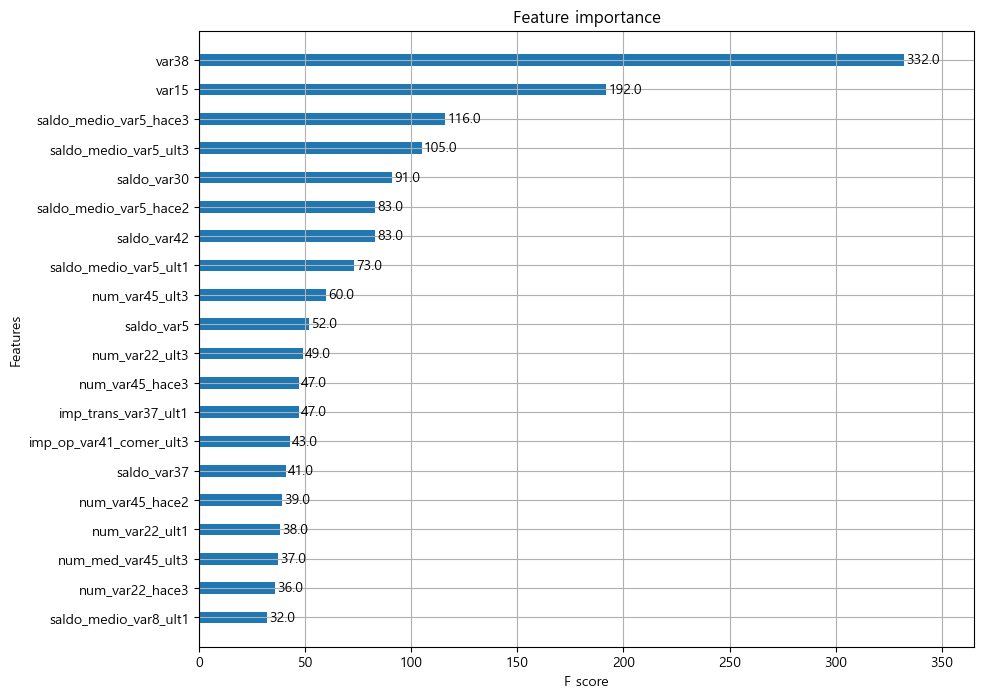

In [50]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(1,1, figsize=(10,8))

plot_importance(xgb_clf, height=0.4, max_num_features=20, ax=ax)
# plot_importance: XGBoost 모델의 피처 중요도를 시각화하는 함수
# 중요도가 높은 순서대로 막대를 그림
# max_num_features(최대로 표시할 피처의 개수)

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [ ]:
from lightgbm import LGBMClassifier
eval_set=[(X_tr, y_tr), (X_val, y_val)]   #학습/검증 데이터

lgbm_clf = LGBMClassifier(n_estimators=500)
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
             eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
# y_test: 테스트 데이터의 실제 클래스 레이블
# lgbm_clf.pred~: 테스트 데이터에 대한 양성 클래스(1)의 예측확률

print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                 'max_depth': hp.quniform('max_depth', 100, 160, 1),
                 'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                 'subsample': hp.uniform('subsample', 0.7, 1),
                 #subsample: 각 트리를 학습할 때 훈련데이터 샘플을 사용하는 비율(0~1 사이)
                 'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)  }

In [ ]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']), 
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30,
                     eval_metric="auc", eval_set=[(X_tr,y_tr), (X_val,y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1]) 
        roc_auc_list.append(score)
    
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials
trials = Trials()

# fmin()함수를 호출. max_evals 지정된 횟수만큼 반복 후 
# 목적함수의 최소값을 가지는 최적 입력값 추출. 
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

In [ ]:
lgbm_clf =  LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                           max_depth=int(best['max_depth']),
                           min_child_samples=int(best['min_child_samples']), 
                           subsample=round(best['subsample'], 5),
                           learning_rate=round(best['learning_rate'], 5)    )

# evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, 
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))